In [2]:
!pip install skfeature-chappers

In [1]:
import os
#do not show warnings
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

Current working directory: C:\Users\gzner\KLARNA_CASE_STUDY


In [5]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime, timezone, timedelta
from scipy.stats import chi2_contingency
#from skfeature.function.similarity_based import fisher_score
import joblib
import pickle
from imblearn import pipeline as imbPipe
from imblearn.over_sampling import SMOTE
#conda install -c conda-forge missingno
import missingno as msno

In [6]:
#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest, chi2
import sklearn.externals
from sklearn import ensemble
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer as ii
from sklearn import base
from sklearn import impute as imp
from sklearn.compose import ColumnTransformer
from sklearn import model_selection as mdl 
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing as prp
from sklearn import metrics as met
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [7]:
#Classifiers
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
#from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


In [10]:
sklearn.__version__

'1.0.2'

Current working directory: C:\Users\gzner\KLARNA_CASE_STUDY


In [8]:
df = pd.read_csv("dataset.csv", sep = ";")
df.head()

,uuid,default,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,...,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours,worst_status_active_inv
0,63f69b2c-8b1c-4740-b78d-52ed9a4515ac,0.0,0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,...,1,1,1,1,0,0,0,178839,9.653333,1.0
1,0e961183-8c15-4470-9a5e-07a1bd207661,0.0,0,0.0,0.0,0.0,NaN,1.0,1.0,1.0,...,1,1,2,2,0,0,0,49014,13.181389,NaN
2,d8edaae6-4368-44e0-941e-8328f203e64e,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,1,1,2,2,0,0,0,124839,11.561944,1.0
3,0095dfb6-a886-4e2a-b056-15ef45fdb0ef,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,0,0,0,324676,15.751111,1.0
4,c8f8b835-5647-4506-bf15-49105d8af30b,0.0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,0,1,1,1,0,0,0,7100,12.698611,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99976 entries, 0 to 99975
Data columns (total 43 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   uuid                                 99976 non-null  object 
 1   default                              89976 non-null  float64
 2   account_amount_added_12_24m          99976 non-null  int64  
 3   account_days_in_dc_12_24m            88140 non-null  float64
 4   account_days_in_rem_12_24m           88140 non-null  float64
 5   account_days_in_term_12_24m          88140 non-null  float64
 6   account_incoming_debt_vs_paid_0_24m  40661 non-null  float64
 7   account_status                       45603 non-null  float64
 8   account_worst_status_0_3m            45603 non-null  float64
 9   account_worst_status_12_24m          33215 non-null  float64
 10  account_worst_status_3_6m            42274 non-null  float64
 11  account_worst_status_6_12m  

In [4]:
df.default.value_counts()

0.0    88688
1.0     1288
Name: default, dtype: int64

In [9]:
df_test = df[df["default"].isnull()]
df_test.shape

(10000, 43)

In [10]:
df_train = df[df["default"] >= 0]
df_train.shape

(89976, 43)

In [11]:
# Check missing data:

def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(tt)

In [9]:
(df_train['default'].value_counts()) / len(df_train) * 100 #highly imbalanced data

0.0    98.568507
1.0     1.431493
Name: default, dtype: float64

In [8]:
%%time
missing_data(df_train)

Wall time: 63.8 ms


,Total,Percent,Types
uuid,0,0.000000,object
default,0,0.000000,float64
account_amount_added_12_24m,0,0.000000,int64
account_days_in_dc_12_24m,10683,11.873166,float64
account_days_in_rem_12_24m,10683,11.873166,float64
account_days_in_term_12_24m,10683,11.873166,float64
account_incoming_debt_vs_paid_0_24m,53357,59.301369,float64
account_status,48934,54.385614,float64
account_worst_status_0_3m,48934,54.385614,float64
account_worst_status_12_24m,60055,66.745577,float64


In [10]:
missing_table = missing_data(df_train)
most_miss_cols = list(missing_table[missing_table['Percent'] > 50].index)
most_miss_cols

['account_incoming_debt_vs_paid_0_24m',
 'account_status',
 'account_worst_status_0_3m',
 'account_worst_status_12_24m',
 'account_worst_status_3_6m',
 'account_worst_status_6_12m',
 'worst_status_active_inv']

In [12]:
print(df_train.duplicated().sum())
print(df_train.uuid.duplicated().sum())

0
0


In [13]:
df_train.dtypes

uuid                                    object
default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                         float64
account_worst_status_0_3m              float64
account_worst_status_12_24m            float64
account_worst_status_3_6m              float64
account_worst_status_6_12m             float64
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                  bool
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_di

<AxesSubplot:>

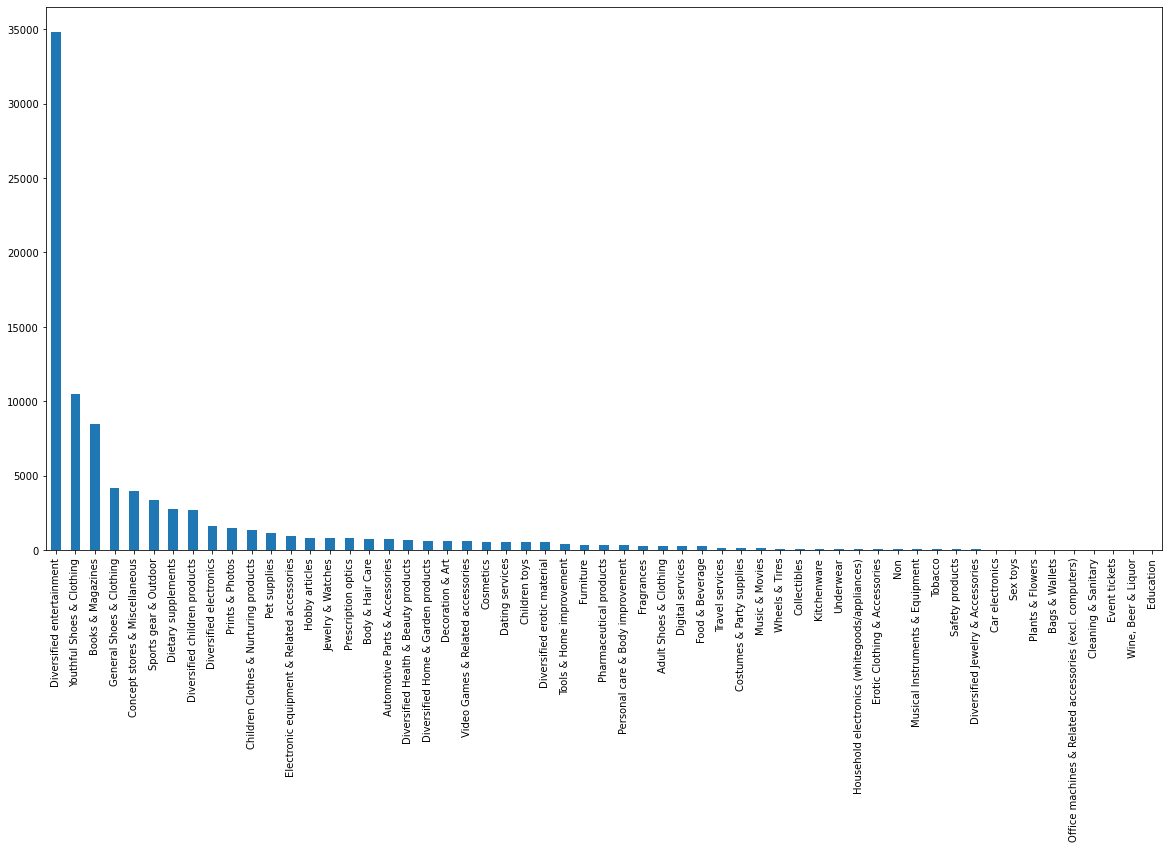

In [19]:
df_train.merchant_category.value_counts().plot(kind="bar", figsize= (20,10))

<AxesSubplot:>

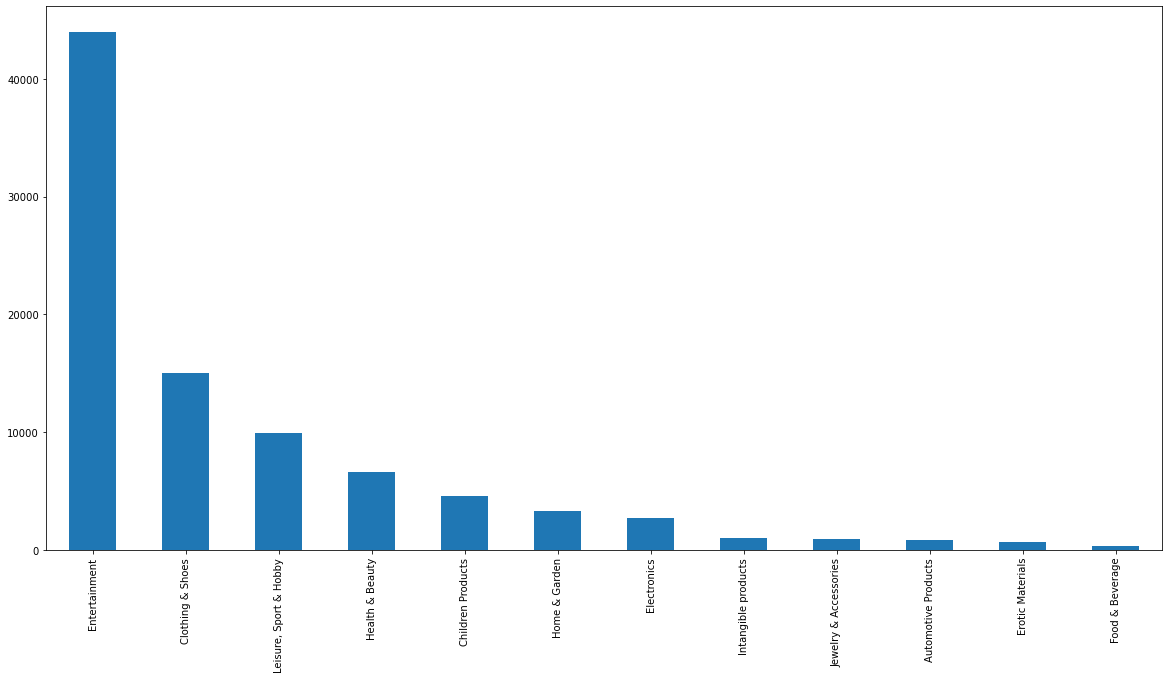

In [20]:
df_train.merchant_group.value_counts().plot(kind="bar", figsize= (20,10))

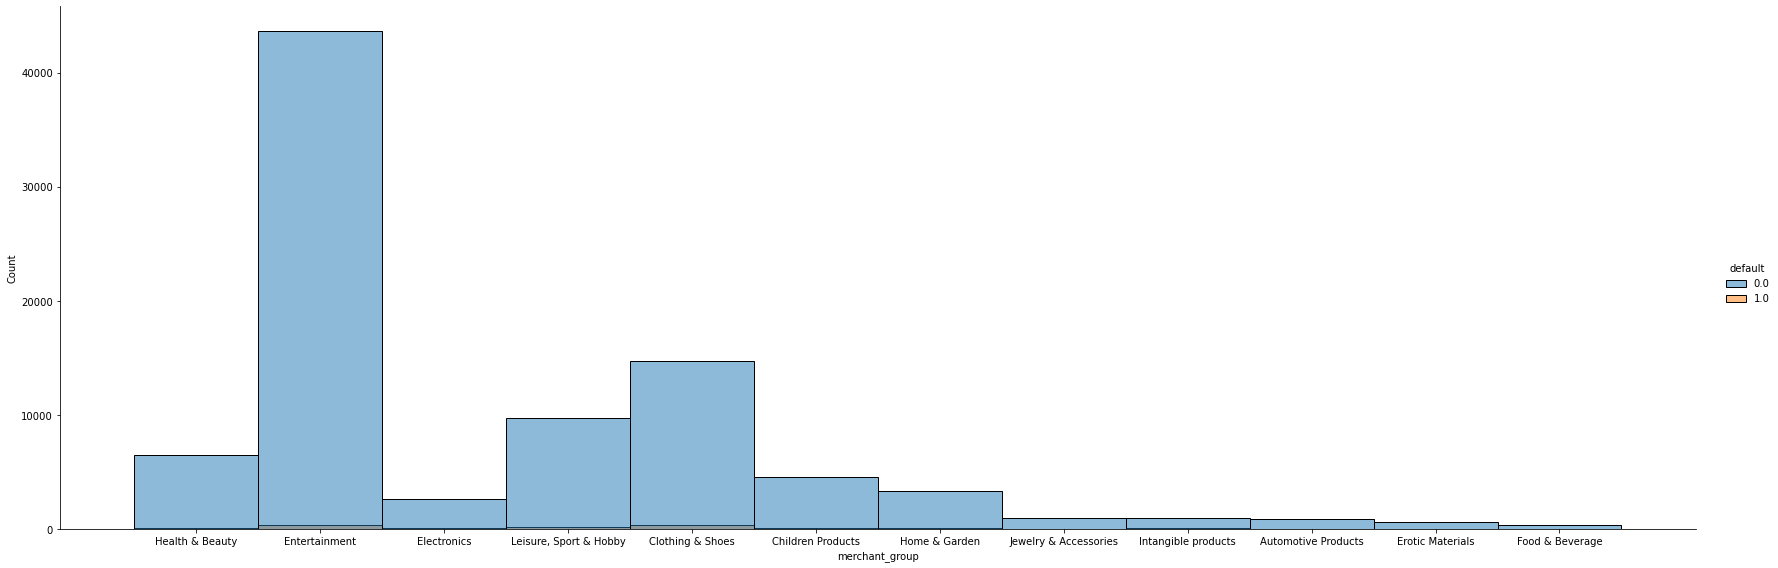

In [34]:
sns.displot(df_train, x="merchant_group", hue="default", height=8, aspect=3)

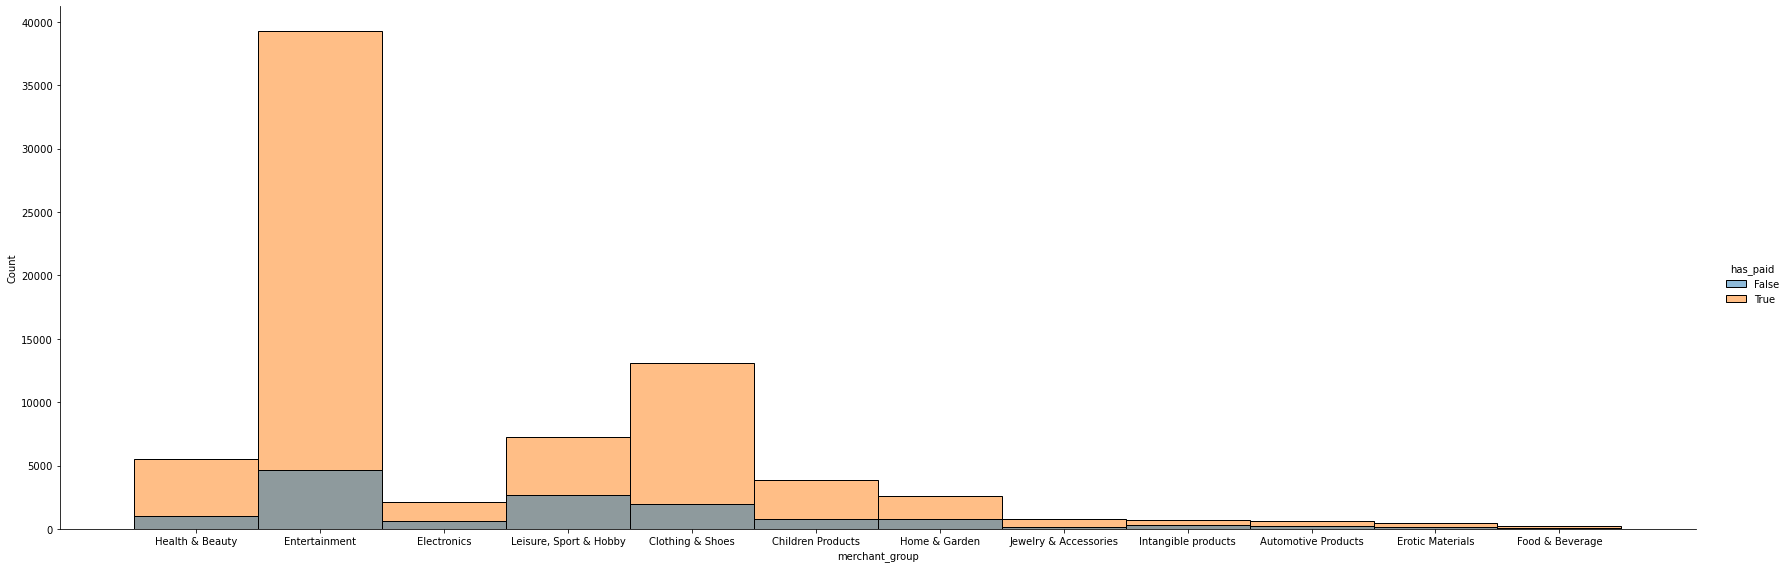

In [38]:
sns.displot(df_train, x="merchant_group", hue="has_paid", height=8, aspect=3)

Binning of object columns is necessary due to their frequency tables. It can contibute to prediction. It can happen that some categorical features have lot of different values with small frequencies. This can often be a problem during modeling phase. 

Typical solution is to merge all categories with small (e.g. 5% , 1% etc… ) frequency of appearance in data set into one category e.g. Other

In [12]:
# set up the threshold percent
threshold_percent = 5

series = pd.value_counts(df_train['merchant_group'])
mask = (series / series.sum() * 100).lt(threshold_percent)
df_train = df_train.assign(merchant_group_upt = np.where(df_train['merchant_group'].isin(series[mask].index),'Other', df_train['merchant_group']))
df_train.merchant_group_upt.value_counts()

Entertainment             43940
Clothing & Shoes          15033
Leisure, Sport & Hobby     9935
Other                      9865
Health & Beauty            6589
Children Products          4614
Name: merchant_group_upt, dtype: int64

In [13]:
threshold_percent = 2

series2 = pd.value_counts(df_train['merchant_category'])
mask2 = (series2 / series2.sum() * 100).lt(threshold_percent)
df_train = df_train.assign(merchant_category_upt = np.where(df_train['merchant_category'].isin(series2[mask2].index),'Other', df_train['merchant_category']))
df_train.merchant_category_upt.value_counts()

Diversified entertainment         34781
Other                             19269
Youthful Shoes & Clothing         10524
Books & Magazines                  8447
General Shoes & Clothing           4162
Concept stores & Miscellaneous     3969
Sports gear & Outdoor              3356
Dietary supplements                2777
Diversified children products      2691
Name: merchant_category_upt, dtype: int64

<AxesSubplot:>

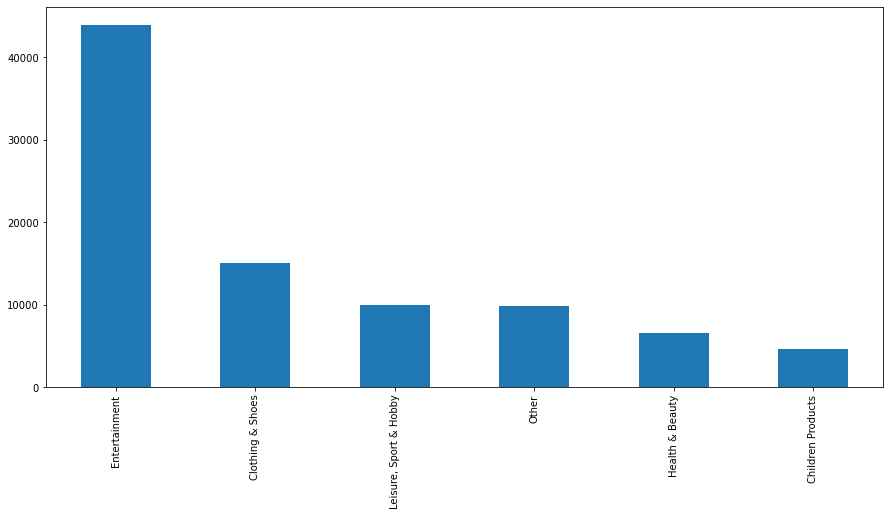

In [52]:
df_train.merchant_group_upt.value_counts().plot(kind="bar", figsize= (15,7))

<AxesSubplot:>

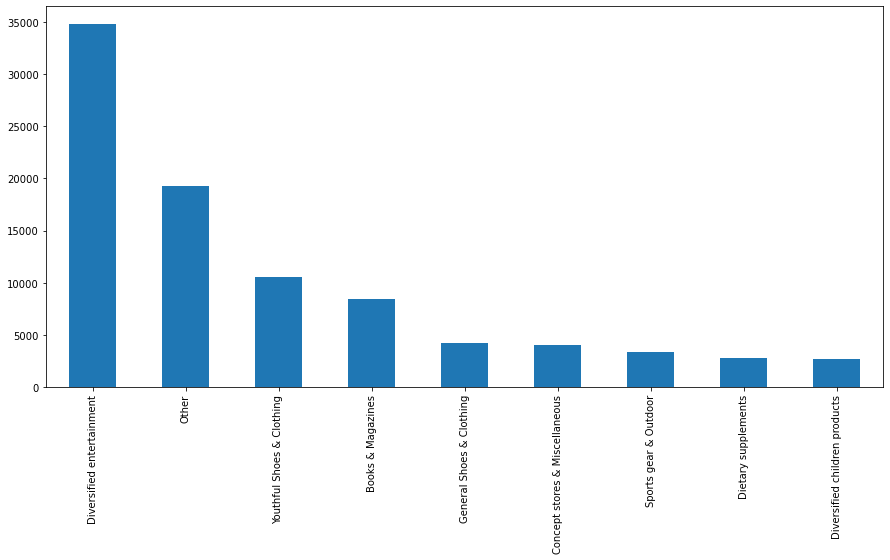

In [53]:
df_train.merchant_category_upt.value_counts().plot(kind="bar", figsize= (15,7))

In [14]:
#Change boolean feature into categorical
df_train['has_paid'] = df_train['has_paid'].astype('object')

In [58]:
df_train.name_in_email.value_counts(), df_train.name_in_email.isnull().sum()

(F+L         36358
 no_match    15094
 L1+F        14495
 F            8755
 Nick         7496
 F1+L         6566
 L            1188
 Initials       24
 Name: name_in_email, dtype: int64,
 0)

"name_in_email" variable seems useless, its categories do not have any meaning excepgt "Nick", "no_match" and "Initials". Additionally, this kind of feature does not have reasonable impact on probability of default. Thus, we will drop this feature.

In [61]:
df_train.dtypes

uuid                                    object
default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                         float64
account_worst_status_0_3m              float64
account_worst_status_12_24m            float64
account_worst_status_3_6m              float64
account_worst_status_6_12m             float64
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                object
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_di

In [15]:
droplist=["name_in_email","merchant_group","merchant_category"]

In [16]:
df_train=df_train.drop(droplist, axis=1)
df_train.shape

(89976, 42)

<AxesSubplot:>

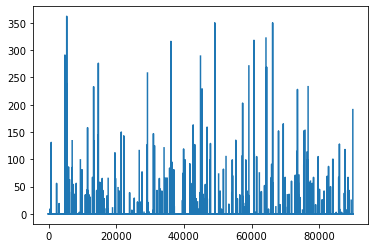

In [65]:
df_train.account_days_in_dc_12_24m.plot()

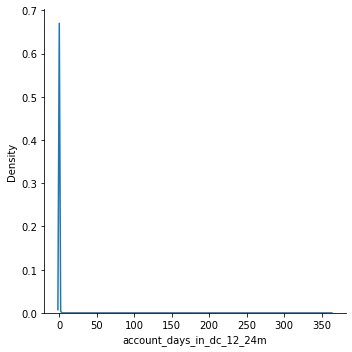

In [66]:
sns.displot(data=df_train, x="account_days_in_dc_12_24m",  kind="kde")

In [69]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
default,89976.0,0.014315,0.118786,0.000000,0.000000,0.000000,0.000000,1.000000e+00
account_amount_added_12_24m,89976.0,12276.154463,35463.557816,0.000000,0.000000,0.000000,4984.250000,1.128775e+06
account_days_in_dc_12_24m,79293.0,0.217333,5.629972,0.000000,0.000000,0.000000,0.000000,3.620000e+02
account_days_in_rem_12_24m,79293.0,5.073840,22.957817,0.000000,0.000000,0.000000,0.000000,3.650000e+02
account_days_in_term_12_24m,79293.0,0.287894,2.930697,0.000000,0.000000,0.000000,0.000000,9.700000e+01
account_incoming_debt_vs_paid_0_24m,36619.0,1.330536,26.924730,0.000000,0.000000,0.153818,0.664694,3.914000e+03
account_status,41042.0,1.041665,0.201766,1.000000,1.000000,1.000000,1.000000,4.000000e+00
account_worst_status_0_3m,41042.0,1.173286,0.420694,1.000000,1.000000,1.000000,1.000000,4.000000e+00
account_worst_status_12_24m,29921.0,1.339227,0.575655,1.000000,1.000000,1.000000,2.000000,4.000000e+00
account_worst_status_3_6m,38038.0,1.185446,0.442856,1.000000,1.000000,1.000000,1.000000,4.000000e+00


There are outliers in the data. In addition, some variables have small variance/deviation while some have very high deviation. Besides, there are actually more categorical variables in data according to given data dictionary. Thus, we firstly redefine this variables as categorical/object variables.

In [17]:
for col in df_train.filter(regex='status').columns:
    df_train[col] = df_train[col].astype('object')
df_train.dtypes

uuid                                    object
default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                          object
account_worst_status_0_3m               object
account_worst_status_12_24m             object
account_worst_status_3_6m               object
account_worst_status_6_12m              object
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
has_paid                                object
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
num_active_div_by_paid_inv_0_12m       float64
num_active_inv                           int64
num_arch_dc_0_12m                        int64
num_arch_dc_1

<AxesSubplot:xlabel='age'>

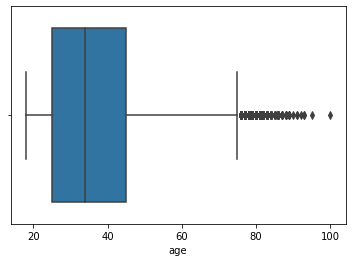

In [70]:
sns.boxplot(df_train['age'])

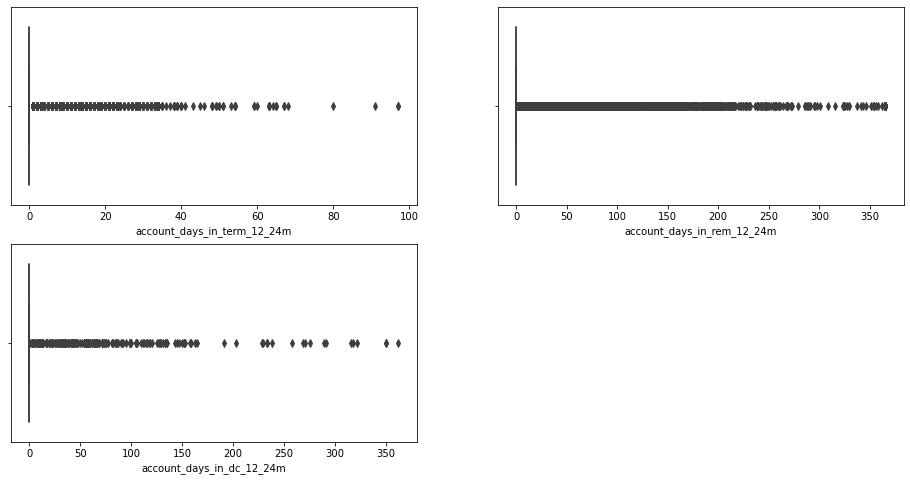

In [74]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.boxplot(df_train['account_days_in_term_12_24m'])
plt.subplot(2,2,2)
sns.boxplot(df_train['account_days_in_rem_12_24m'])
plt.subplot(2,2,3)
sns.boxplot(df_train['account_days_in_dc_12_24m'])
plt.show()

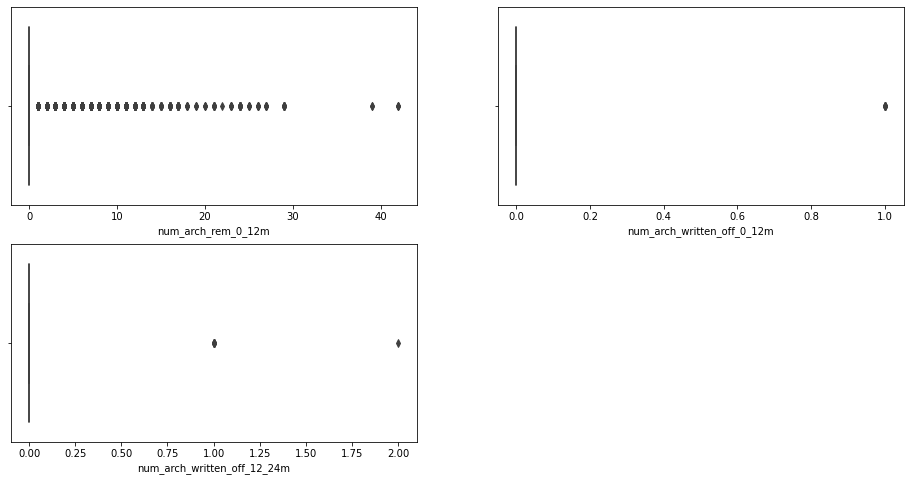

In [73]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.boxplot(df_train['num_arch_rem_0_12m'])
plt.subplot(2,2,2)
sns.boxplot(df_train['num_arch_written_off_0_12m'])
plt.subplot(2,2,3)
sns.boxplot(df_train['num_arch_written_off_12_24m'])
plt.show()

In [18]:
#First, we separate our target value and remaining predictors.
ID = df_train['uuid']
y_target = df_train['default']
X = df_train.iloc[:,2:]

ID.shape, y_target.shape, X.shape, df_train.shape

((89976,), (89976,), (89976, 40), (89976, 42))

In [123]:
"""""
#Lets look at outliers over whole train data via one of auto outlier detection algorithm:
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X[X.select_dtypes(exclude = "object").columns].fillna(X.mean()))
yhat

array([1, 1, 1, ..., 1, 1, 1])

In [124]:
"""""
lof = LocalOutlierFactor(contamination=0.1)
yhat2 = lof.fit_predict(X[X.select_dtypes(exclude = "object").columns].fillna(X.mean()))
yhat2 

array([ 1,  1,  1, ...,  1,  1, -1])

In [125]:
#Both algorithms above give similar output for outlier detection. Remember that their output is based on rows rather than columns. 
#Namely, they detect outliers in rows, indeed.
pred_trial = pd.DataFrame({'pred': yhat,
                    'pred2': yhat2})
pred_trial

,pred,pred2
0,1,1
1,1,1
2,1,1
3,-1,1
4,1,1
...,...,...
89971,1,1
89972,1,1
89973,1,1
89974,1,1


In [126]:
pred_trial.pred.value_counts(), pred_trial.pred2.value_counts()

( 1    80978
 -1     8998
 Name: pred, dtype: int64,
  1    80978
 -1     8998
 Name: pred2, dtype: int64)

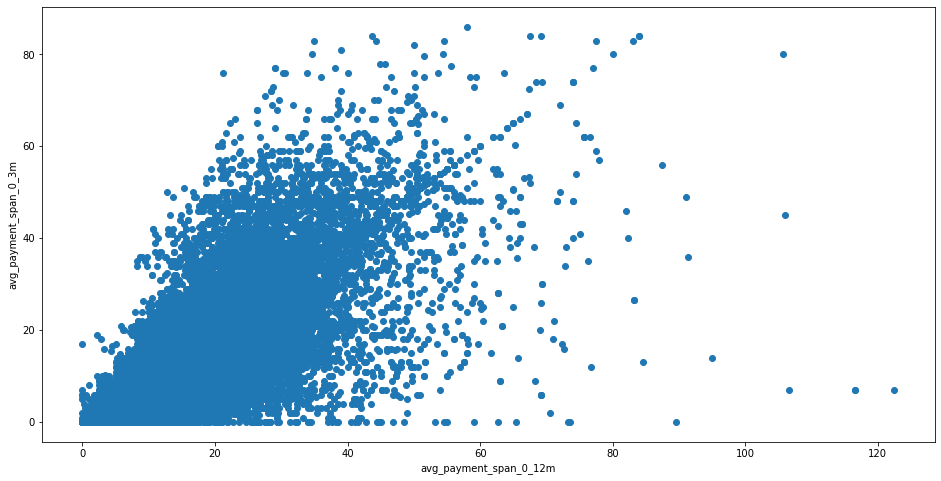

In [127]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(X['avg_payment_span_0_12m'], X['avg_payment_span_0_3m'])
ax.set_xlabel('avg_payment_span_0_12m')
ax.set_ylabel('avg_payment_span_0_3m')
plt.show()

Looking at the plot above, most of data points are lying left side but there are points which are far from the population like bottom right corner.

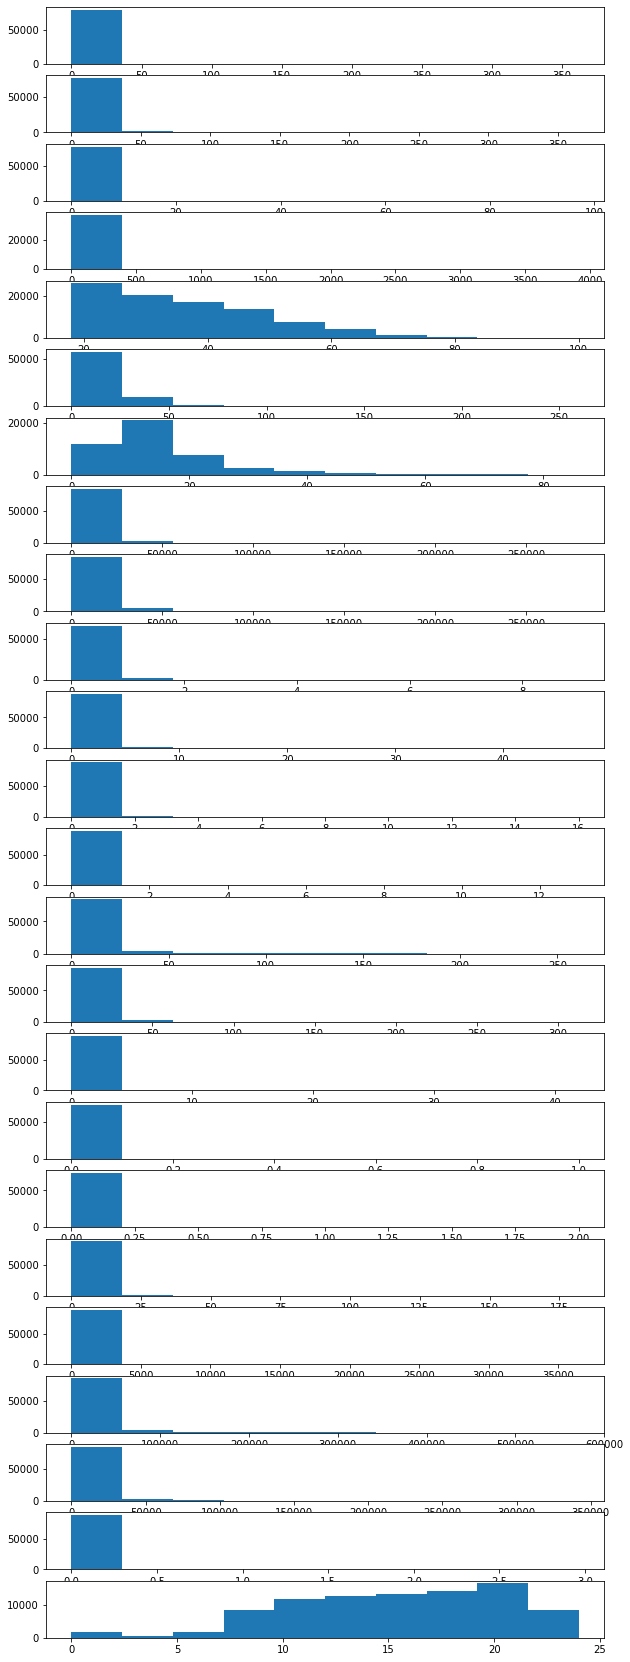

In [128]:
fig, axs = plt.subplots(nrows=len(X[X.select_dtypes(exclude="object").columns].columns), ncols=1, figsize=(10, 30))
for i, col in enumerate(X[X.select_dtypes(exclude="object").columns].columns):   
    #ax=plt.subplot(2,1,i) 
    #print(col)
    axs[i].hist(X[col])
    
plt.show()

KeyboardInterrupt: 

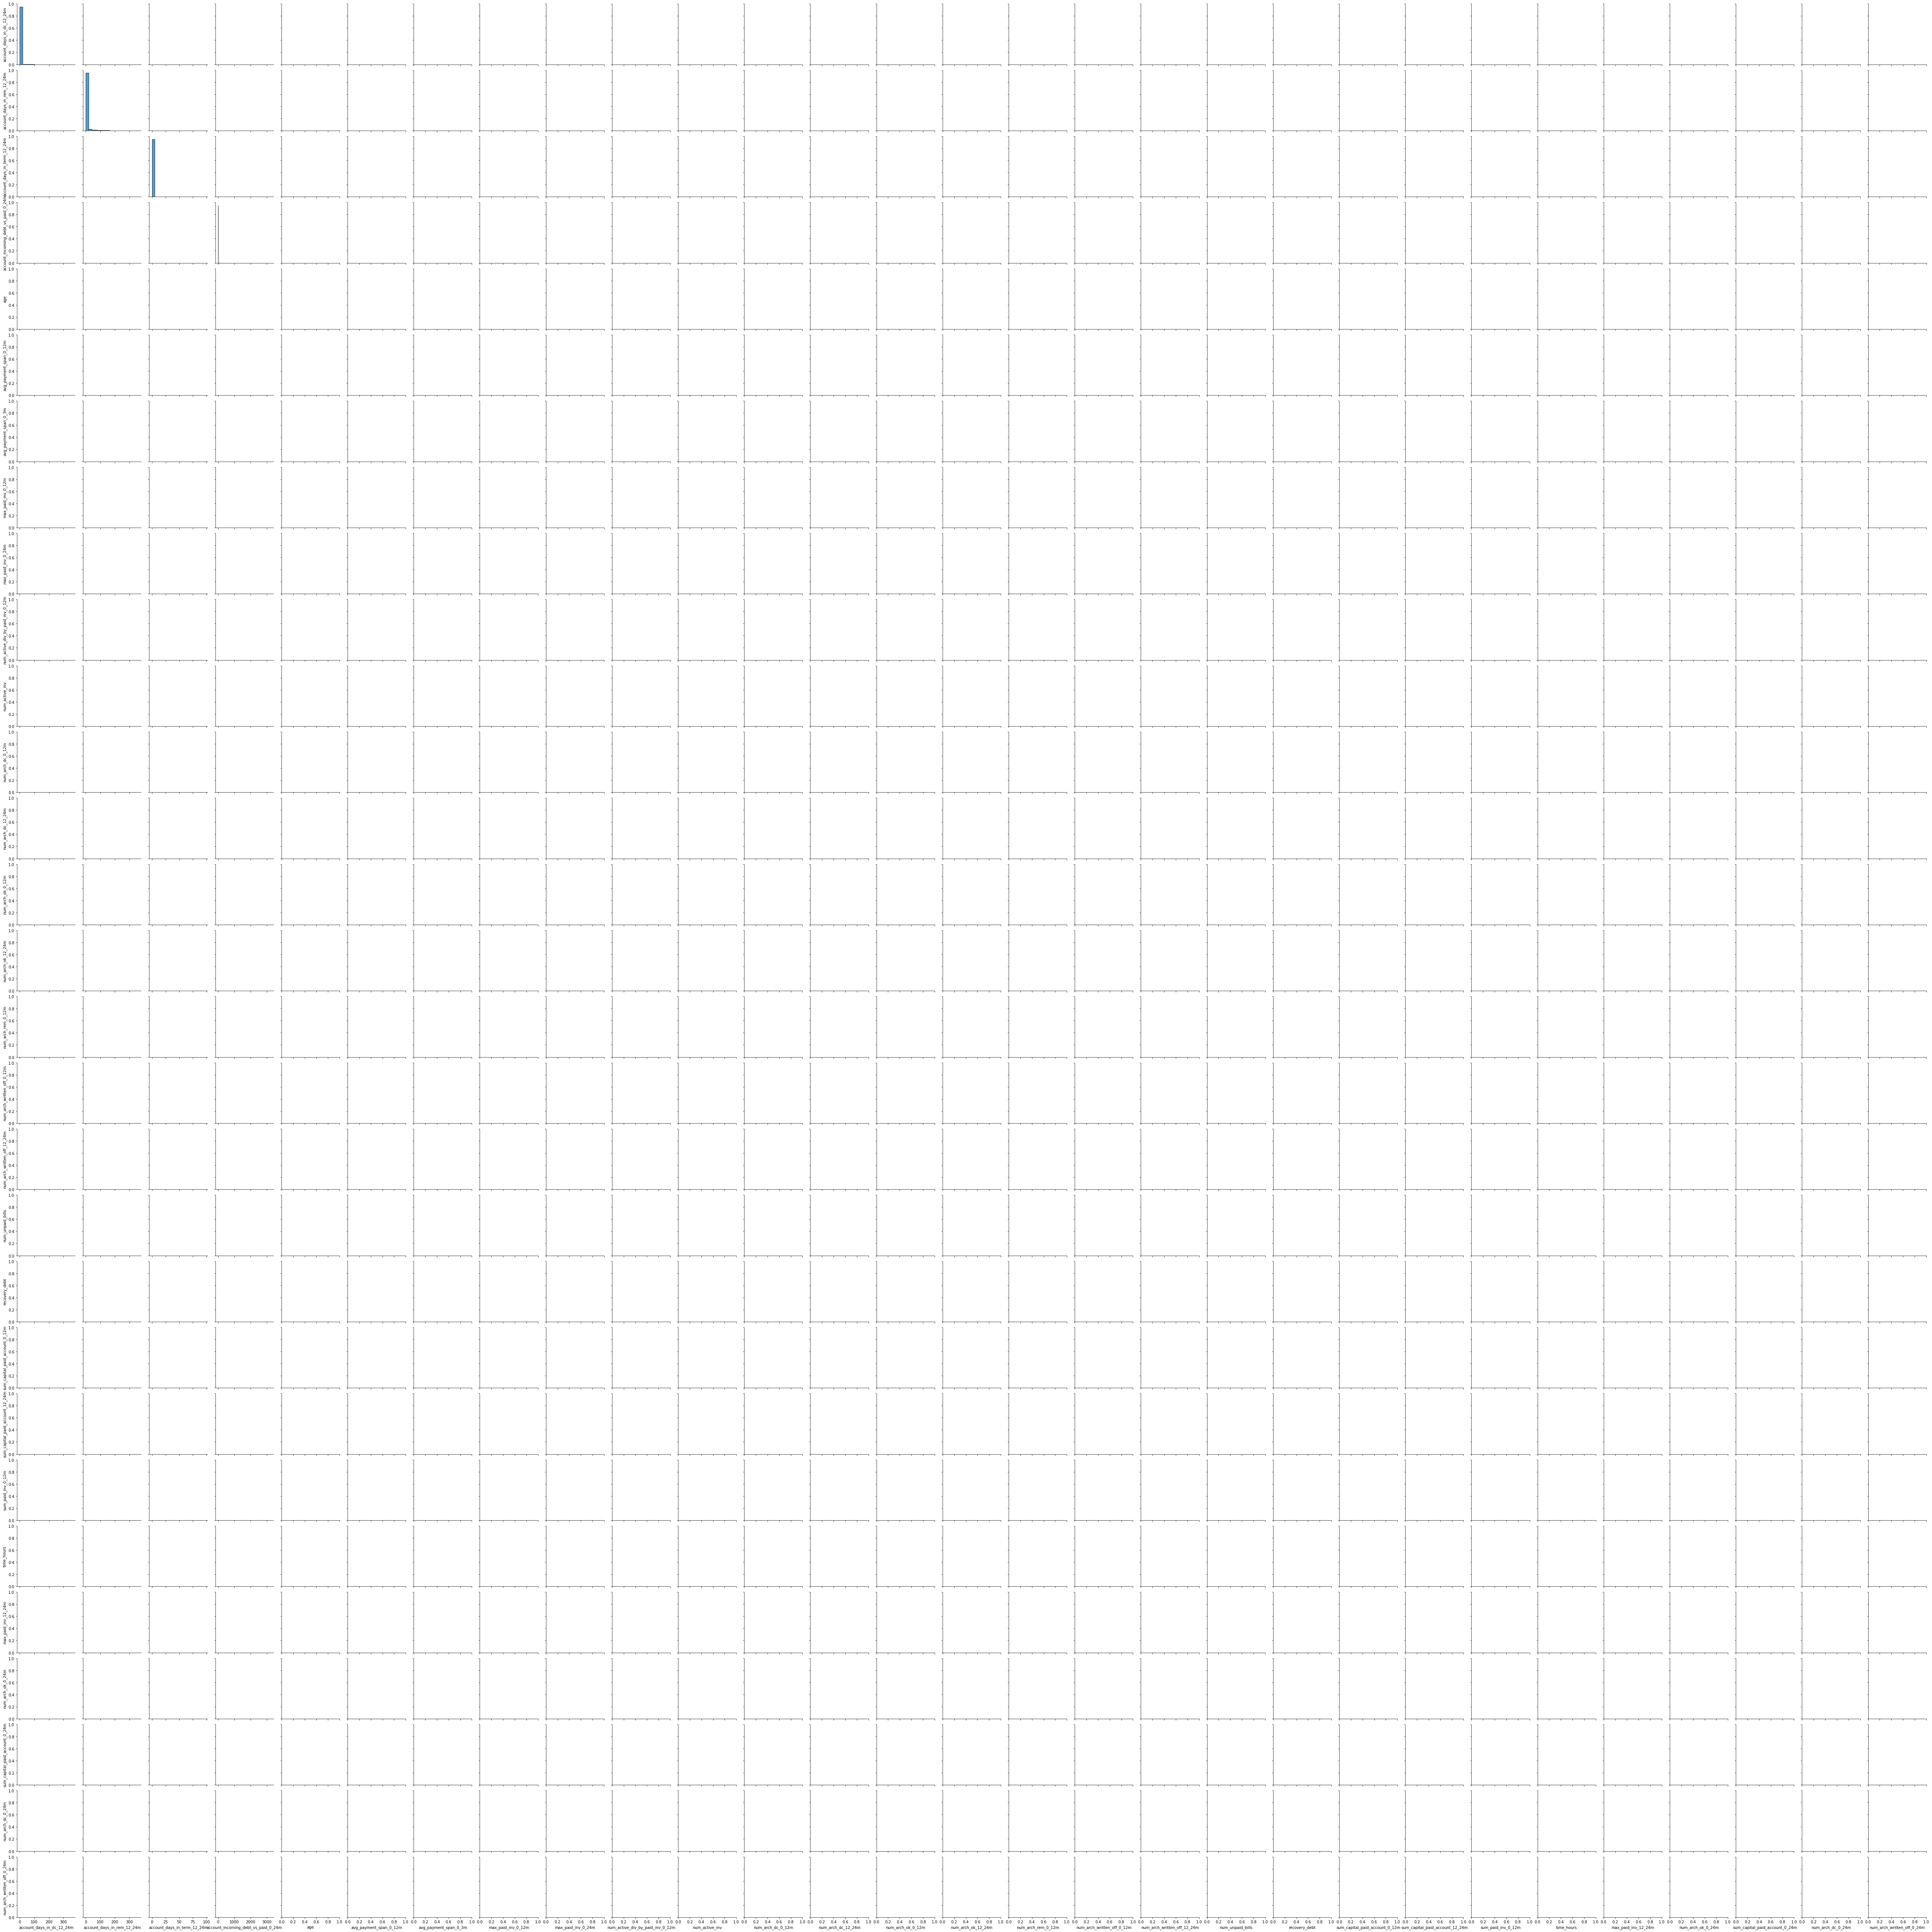

In [242]:
"""""
sns.pairplot(X[X.select_dtypes(exclude ="object").columns])

Here, we can see that most of variables have skewed distribution. Thus, z score can not be used for another outlier detection method. Interquantiler Range will be more usefull for this.

In [274]:
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
#Here we will get IQR for each column.
print(IQR)

account_amount_added_12_24m             4984.250000
account_days_in_dc_12_24m                  0.000000
account_days_in_rem_12_24m                 0.000000
account_days_in_term_12_24m                0.000000
account_incoming_debt_vs_paid_0_24m        0.664694
age                                       20.000000
avg_payment_span_0_12m                    10.240124
avg_payment_span_0_3m                      9.822222
max_paid_inv_0_12m                      9380.000000
max_paid_inv_0_24m                     10470.000000
num_active_div_by_paid_inv_0_12m           0.100000
num_active_inv                             1.000000
num_arch_dc_0_12m                          0.000000
num_arch_dc_12_24m                         0.000000
num_arch_ok_0_12m                          7.000000
num_arch_ok_12_24m                         6.000000
num_arch_rem_0_12m                         0.000000
num_arch_written_off_0_12m                 0.000000
num_arch_written_off_12_24m                0.000000
num_unpaid_b

In [275]:
#it’s time to get hold on outliers. The below code will give an output with some true and false values. 
#The data point where we have False that means these values are valid whereas True indicates presence of an outlier.
print(X[X.select_dtypes(exclude="object").columns] < (Q1 - 1.5 * IQR)) |(X[X.select_dtypes(exclude="object").columns] > (Q3 + 1.5 * IQR))

       account_amount_added_12_24m  account_days_in_dc_12_24m  \
0                            False                      False   
1                            False                      False   
2                            False                      False   
3                            False                      False   
4                            False                      False   
...                            ...                        ...   
89971                        False                      False   
89972                        False                      False   
89973                        False                      False   
89974                        False                      False   
89975                        False                      False   

       account_days_in_rem_12_24m  account_days_in_term_12_24m  \
0                           False                        False   
1                           False                        False   
2                    

TypeError: Cannot perform 'ror_' with a dtyped [bool] array and scalar of type [NoneType]

In [277]:
Q99 = X.quantile(0.99)
Q01 = X.quantile(0.01)
X2 = Q99.reset_index().T
colnames= X2.iloc[0,:].to_list()
X2.columns = colnames
X2 = X2.iloc[1:]
X2

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,...,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
0.99,164684.5,0.0,118.0,10.0,12.771436,70.0,66.5,52.0,63825.0,72095.0,...,74.0,6.0,0.0,0.0,26.0,0.0,122307.5,93523.5,341248.5,23.485069


In [278]:
check = pd.DataFrame()
for col in X[X.select_dtypes(exclude ="object").columns].columns:
    up_lim = X2[col].ravel()
    check[col] = X[col].apply(lambda i: True if i>up_lim else False)
check.shape

(89976, 25)

In [279]:
check.loc[check['account_amount_added_12_24m'].isin([True])]

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,age,avg_payment_span_0_12m,avg_payment_span_0_3m,max_paid_inv_0_12m,max_paid_inv_0_24m,...,num_arch_ok_12_24m,num_arch_rem_0_12m,num_arch_written_off_0_12m,num_arch_written_off_12_24m,num_unpaid_bills,recovery_debt,sum_capital_paid_account_0_12m,sum_capital_paid_account_12_24m,sum_paid_inv_0_12m,time_hours
400,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,True,False,False,False
456,True,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
1053,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,True,True,False
1121,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
1182,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89131,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89481,True,False,False,False,False,False,False,False,False,False,...,True,False,False,False,True,False,False,True,True,False
89549,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
89651,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


Now we detect the outliers, it is important to understand if they needs to be removed or corrected. We can consider a few methods of removing the outliers and if required imputing new values. Despite all this, as much as we’d like to, it is NOT acceptable to drop an observation just because it is an outlier.  They can be legitimate observations and are sometimes the most interesting ones. It’s important to investigate the nature of the outlier before deciding. 

<AxesSubplot:>

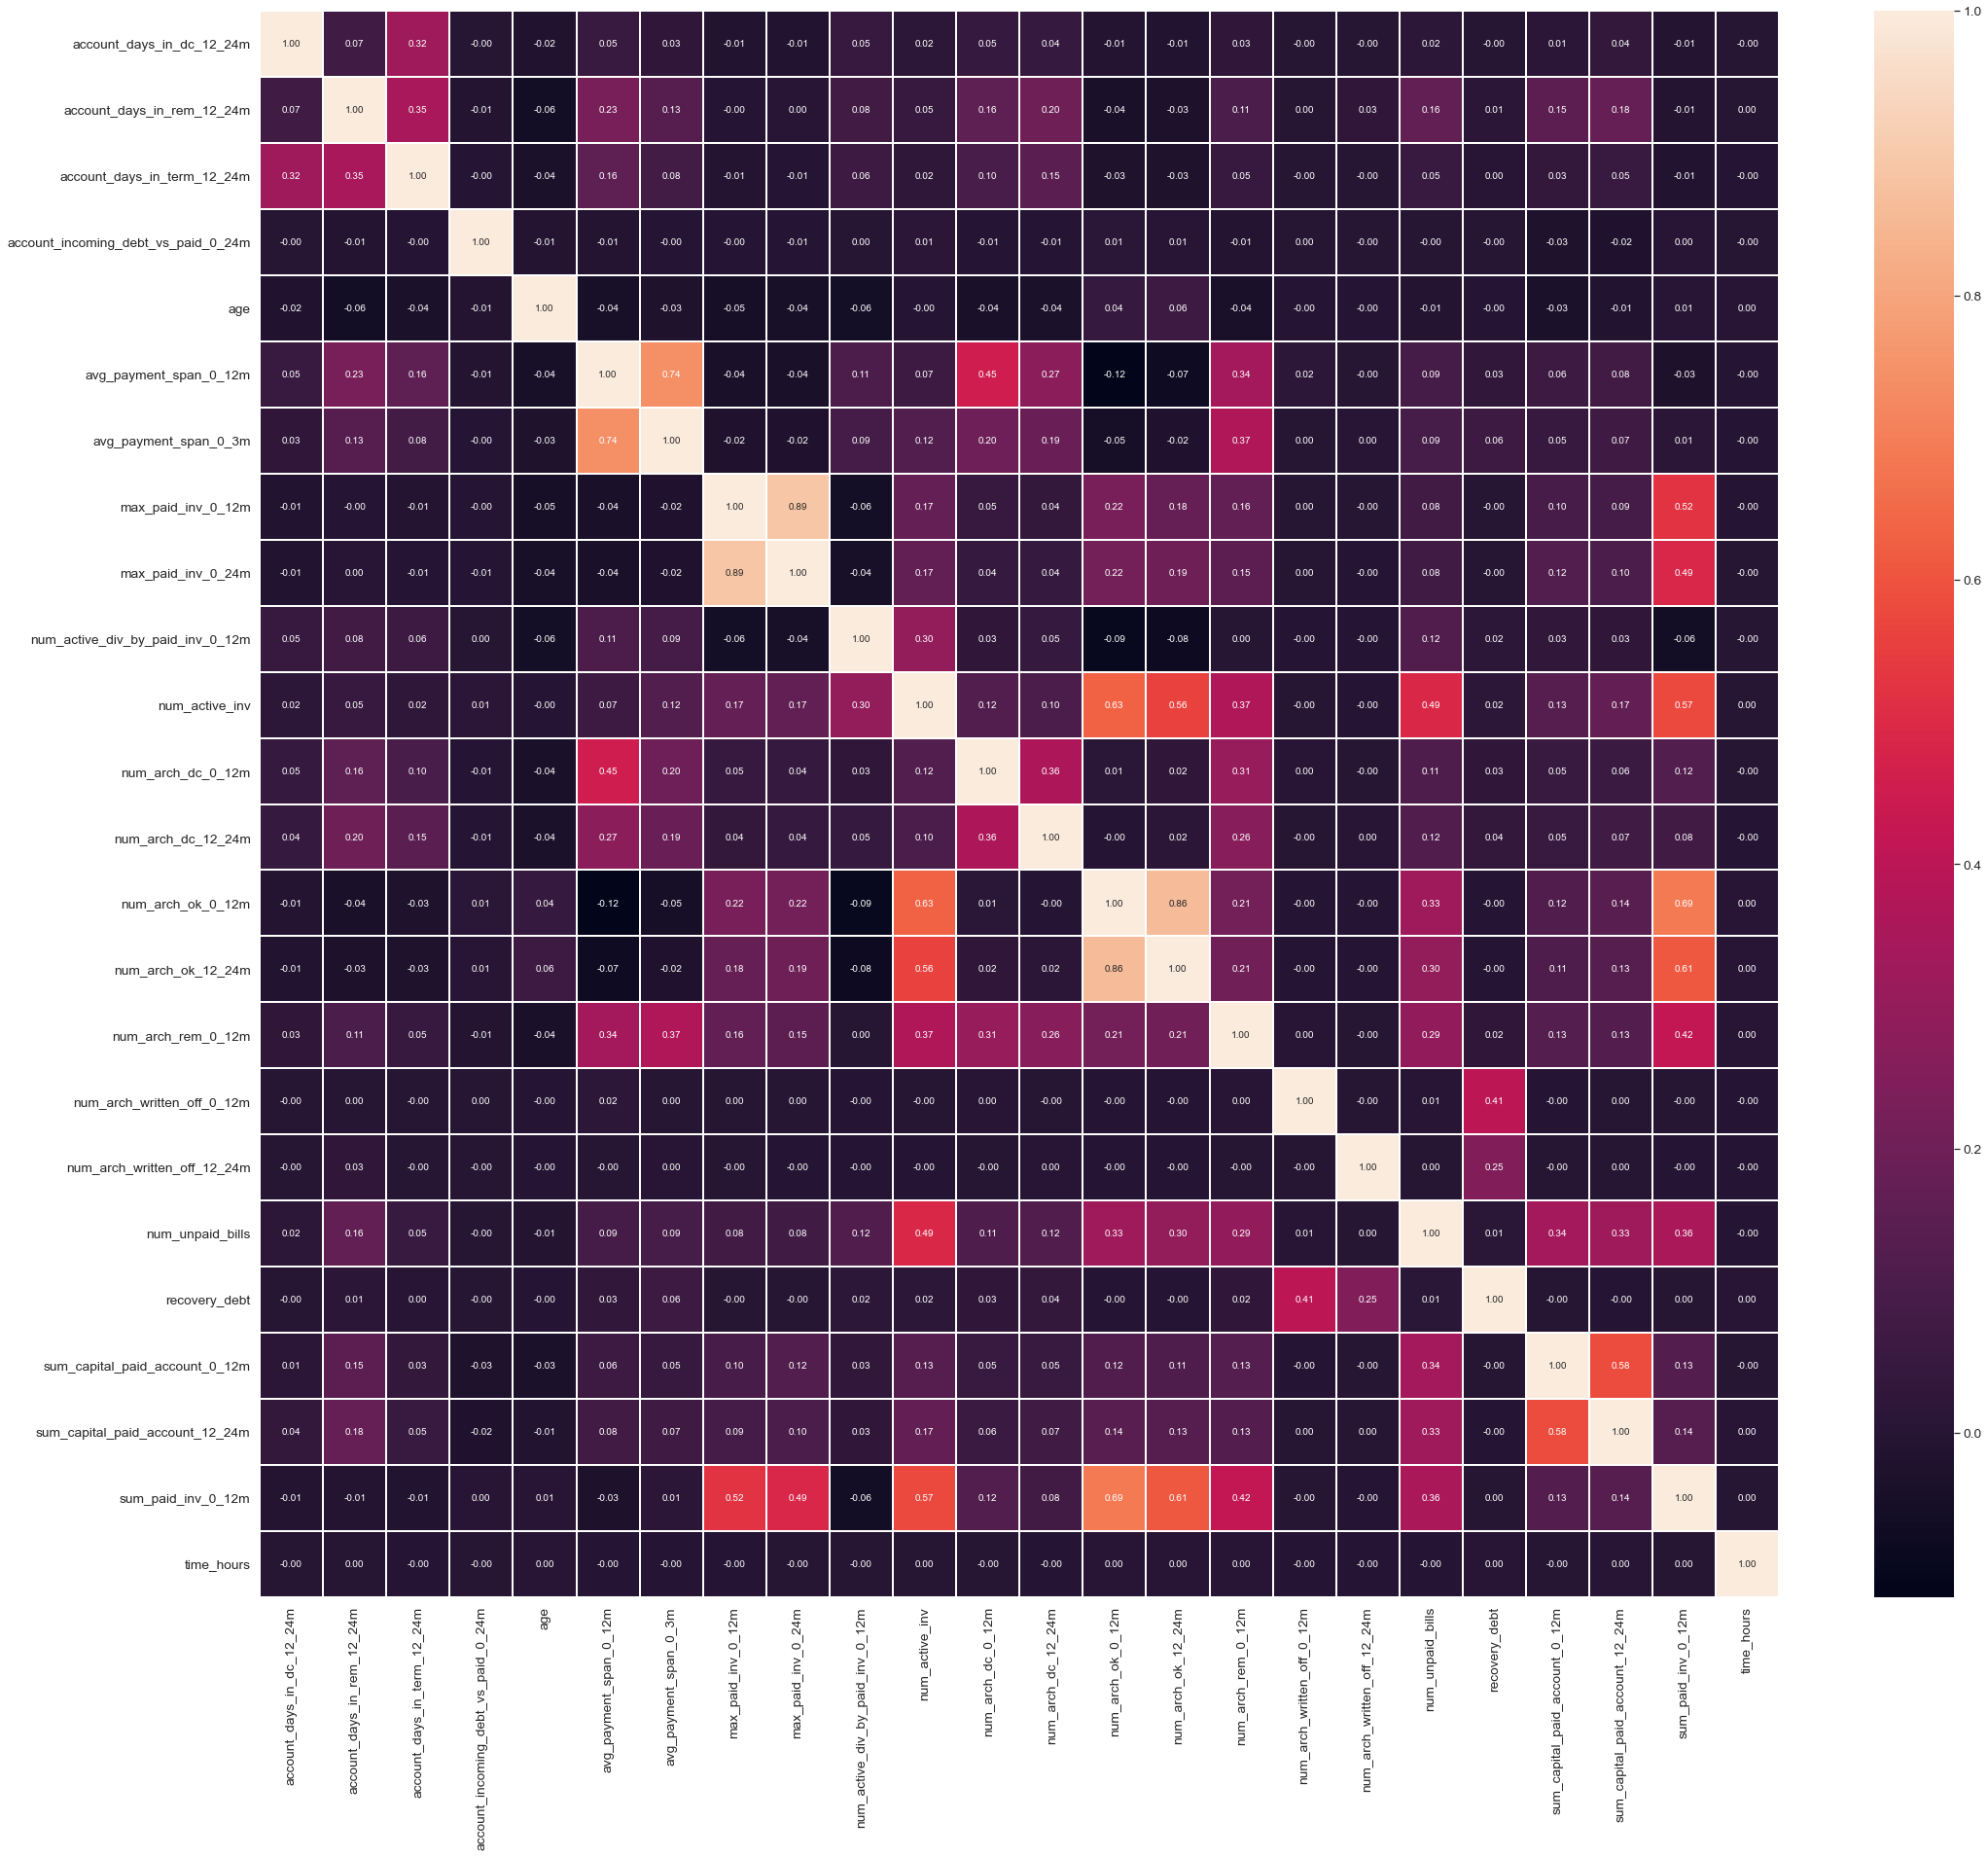

In [280]:
#Correlation
corr = X.iloc[: , 1:].corr()
plt.figure(figsize = (35,30))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")

In [19]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

There are highly correlated inputs which resembles each other. We can create variables by using them so that we reduce the correlation problem. However, we should deal with missing values before doing new inputs. Now, we get correlated pairs more properly.

In [282]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(X[X.select_dtypes(exclude= "object").columns], 20))

Top Absolute Correlations
max_paid_inv_0_12m              max_paid_inv_0_24m                 0.889912
num_arch_ok_0_12m               num_arch_ok_12_24m                 0.864148
avg_payment_span_0_12m          avg_payment_span_0_3m              0.742573
account_amount_added_12_24m     sum_capital_paid_account_12_24m    0.706692
num_arch_ok_0_12m               sum_paid_inv_0_12m                 0.688981
account_amount_added_12_24m     sum_capital_paid_account_0_12m     0.655395
num_active_inv                  num_arch_ok_0_12m                  0.632183
num_arch_ok_12_24m              sum_paid_inv_0_12m                 0.609218
sum_capital_paid_account_0_12m  sum_capital_paid_account_12_24m    0.584943
num_active_inv                  sum_paid_inv_0_12m                 0.573899
                                num_arch_ok_12_24m                 0.561869
max_paid_inv_0_12m              sum_paid_inv_0_12m                 0.524892
num_active_inv                  num_unpaid_bills              

If we have known more details about data dictionary it would be easier to understand these correlations. However, some features look like as if formed in a similar way. For example, we look at "status_max_archived_0_12_months" and "status_max_archived_0_24_months". "status_max_archived_0_24_months" is 24-months version of "status_max_archived_0_12_months". We can combine this kind of variable so that we can eliminate correlation problem. At least, we can try this for highly correlated ones. 

Firstly, we derive new variables:

In [20]:
X2 = X.copy()
X2["max_paid_inv_12_24m"] = X2.max_paid_inv_0_12m / X2.max_paid_inv_0_24m
X2["num_arch_ok_12_24m"] = X2.num_arch_ok_0_12m / (X2.num_arch_ok_0_12m + X2.num_arch_ok_12_24m)
X2["num_arch_ok_0_24m"] = X2.num_arch_ok_0_12m + X2.num_arch_ok_12_24m
X2["avg_payment_span_3_12m"] = X2.avg_payment_span_0_3m / (X2.avg_payment_span_0_12m+1) #in case dominator is NA 
X2["sum_capital_paid_account_12_24m"] = X2.sum_capital_paid_account_0_12m / (X2.sum_capital_paid_account_0_12m + X2.sum_capital_paid_account_12_24m)
X2["sum_capital_paid_account_0_24m"] = X2.sum_capital_paid_account_0_12m + X2.sum_capital_paid_account_12_24m

X2["sum_capital_paid_account_12_24m"] = X2.num_arch_dc_0_12m / (X2.num_arch_dc_0_12m + X2.num_arch_dc_12_24m)
X2["sum_capital_paid_account_0_24m"] = X2.num_arch_dc_0_12m + X2.num_arch_dc_12_24m

X2["num_arch_dc_12_24m"] = X2.num_arch_dc_0_12m / (X2.num_arch_dc_0_12m + X2.num_arch_dc_12_24m)
X2["num_arch_dc_0_24m"] = X2.num_arch_dc_0_12m + X2.num_arch_dc_12_24m

X2["num_arch_written_off_12_24m"] = X2.num_arch_written_off_0_12m / (X2.num_arch_written_off_0_12m + X2.num_arch_written_off_12_24m)
X2["num_arch_written_off_0_24m"] = X2.num_arch_written_off_0_12m + X2.num_arch_written_off_12_24m

X2.shape

(89976, 46)

In [21]:
df_test2 = df_test.copy()
df_test2["max_paid_inv_12_24m"] = df_test2.max_paid_inv_0_12m / X2.max_paid_inv_0_24m
df_test2["num_arch_ok_12_24m"] = df_test2.num_arch_ok_0_12m / (df_test2.num_arch_ok_0_12m + df_test2.num_arch_ok_12_24m)
df_test2["num_arch_ok_0_24m"] = df_test2.num_arch_ok_0_12m + df_test2.num_arch_ok_12_24m
df_test2["avg_payment_span_3_12m"] = df_test2.avg_payment_span_0_3m / (df_test2.avg_payment_span_0_12m+1) #in case dominator is NA 
df_test2["sum_capital_paid_account_12_24m"] = df_test2.sum_capital_paid_account_0_12m / (df_test2.sum_capital_paid_account_0_12m + df_test2.sum_capital_paid_account_12_24m)
df_test2["sum_capital_paid_account_0_24m"] = df_test2.sum_capital_paid_account_0_12m + df_test2.sum_capital_paid_account_12_24m


df_test2["num_arch_dc_12_24m"] = df_test2.num_arch_dc_0_12m / (df_test2.num_arch_dc_0_12m + df_test2.num_arch_dc_12_24m)
df_test2["num_arch_dc_0_24m"] = df_test2.num_arch_dc_0_12m + df_test2.num_arch_dc_12_24m

df_test2["num_arch_written_off_12_24m"] = df_test2.num_arch_written_off_0_12m / (df_test2.num_arch_written_off_0_12m + df_test2.num_arch_written_off_12_24m)
df_test2["num_arch_written_off_0_24m"] = df_test2.num_arch_written_off_0_12m + df_test2.num_arch_written_off_12_24m

df_test2.shape, df_test.shape

((10000, 49), (10000, 43))

In [22]:
for col in df_test2.filter(regex='status').columns:
    df_test2[col] = df_test2[col].astype('object')
df_test2.dtypes

uuid                                    object
default                                float64
account_amount_added_12_24m              int64
account_days_in_dc_12_24m              float64
account_days_in_rem_12_24m             float64
account_days_in_term_12_24m            float64
account_incoming_debt_vs_paid_0_24m    float64
account_status                          object
account_worst_status_0_3m               object
account_worst_status_12_24m             object
account_worst_status_3_6m               object
account_worst_status_6_12m              object
age                                      int64
avg_payment_span_0_12m                 float64
avg_payment_span_0_3m                  float64
merchant_category                       object
merchant_group                          object
has_paid                                  bool
max_paid_inv_0_12m                     float64
max_paid_inv_0_24m                     float64
name_in_email                           object
num_active_di

<AxesSubplot:>

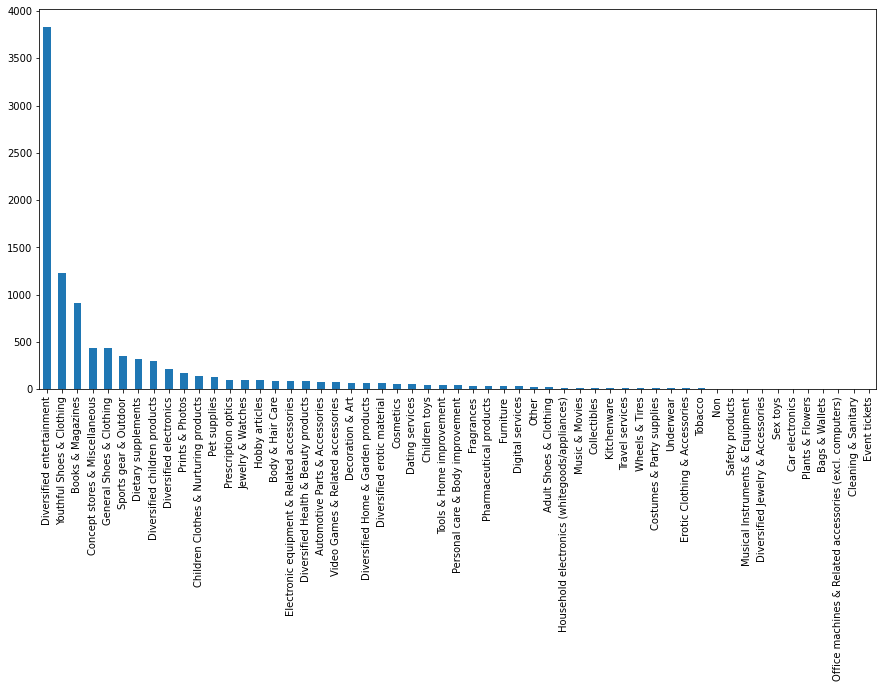

In [23]:
df_test2 = df_test2.assign(merchant_category_upt = np.where(df_test2['merchant_category'].isin(series2[mask2].index),'Other', df_test2['merchant_category']))
df_test2.merchant_category_upt.value_counts()

df_test2 = df_test2.assign(merchant_group_upt = np.where(df_test2['merchant_group'].isin(series[mask].index),'Other', df_test2['merchant_group']))

df_test2['has_paid'] = df_test2['has_paid'].astype('object')

df_test2.merchant_category_upt.value_counts().plot(kind="bar", figsize= (15,7))

<AxesSubplot:>

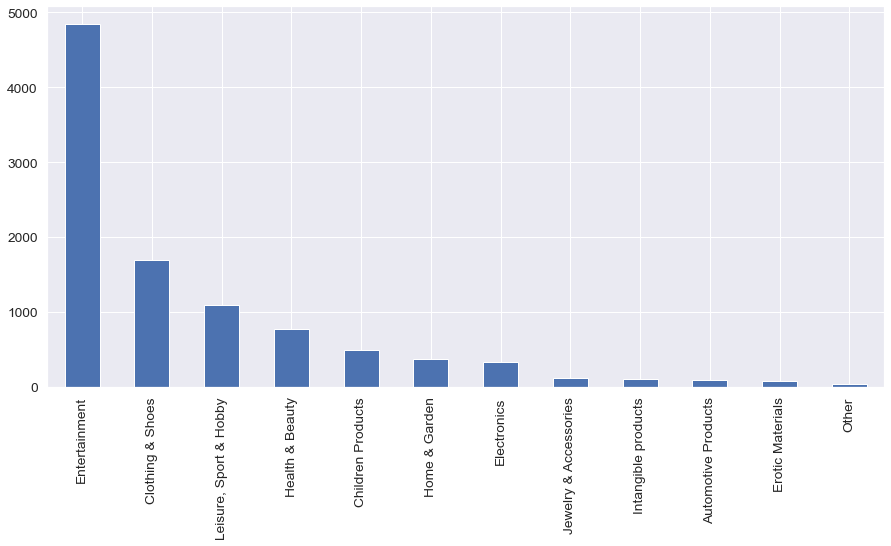

In [480]:
df_test2.merchant_group_upt.value_counts().plot(kind="bar", figsize= (15,7))

In [227]:
#Correlations for categorical variables:
#Null hypothesis: There are relationships between the categorical variables. 
#Therefore, 
#If calculated Statistic >= Critical Value: significant result, reject null hypothesis (H0), dependent.
#If calculated Statistic < Critical Value: not significant result, fail to reject null hypothesis (H0),
#If p-value <= alpha: significant result, reject null hypothesis (H0), dependent.
#If p-value > alpha: not significant result, fail to reject null hypothesis (H0), independent.


X2_cat = X2[X2.select_dtypes(include="object").columns]
X2_cat.shape

(89976, 15)

In [228]:
factors_paired = [(i,j) for i in X2_cat.columns.values for j in X2_cat.columns.values] 

chi2, p_values =[], []

for f in factors_paired:
    if f[0] != f[1]:
        chitest = chi2_contingency(pd.crosstab(X2_cat[f[0]], X2_cat[f[1]]))   
        chi2.append(chitest[0])
        p_values.append(chitest[1])
    else:      # for same factor pair
        chi2.append(0)
        p_values.append(0)

In [231]:
chi2 = np.array(chi2).reshape((15,15)) # shape it as a matrix
chi2 = pd.DataFrame(chi2, index=X2_cat.columns.values, columns=X2_cat.columns.values) # then a df for convenience
chi2

,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,has_paid,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,worst_status_active_inv,merchant_group_upt,merchant_category_upt
account_status,0.000000,11631.263938,709.635427,3441.917215,1780.751237,3.181123,14127.193123,335.196915,313.806278,395.076504,2461.502115,1517.485458,183.031941,92.338221,116.560502
account_worst_status_0_3m,11631.263938,0.000000,3099.902246,19765.762579,5900.477607,33.722834,2374.734128,1875.623461,1379.834739,1746.491273,2374.928004,2333.254947,314.046541,168.498069,201.765790
account_worst_status_12_24m,709.635427,3099.902246,0.000000,3470.419098,8778.491495,4.984877,2187.074434,1961.627616,1665.045769,1513.131107,2315.068213,3268.602694,314.231941,206.344471,244.817306
account_worst_status_3_6m,3441.917215,19765.762579,3470.419098,0.000000,14567.177255,3.973770,2350.377255,1942.985666,1562.191095,1561.266137,2337.847363,2375.976963,197.362405,143.202581,183.093127
account_worst_status_6_12m,1780.751237,5900.477607,8778.491495,14567.177255,0.000000,4.416217,2077.391572,2124.080350,1823.918223,1481.741735,2670.425981,3067.006959,309.927301,226.536320,239.453152
has_paid,3.181123,33.722834,4.984877,3.973770,4.416217,0.000000,67494.608238,40445.369506,29407.670546,27576.315546,49111.425972,67494.802232,75.907175,2312.137504,2837.742716
status_last_archived_0_24m,14127.193123,2374.734128,2187.074434,2350.377255,2077.391572,67494.608238,0.000000,88630.952198,45342.632953,71853.644407,109743.231569,133145.610558,855.070896,3702.607927,4226.947517
status_2nd_last_archived_0_24m,335.196915,1875.623461,1961.627616,1942.985666,2124.080350,40445.369506,88630.952198,0.000000,78237.563726,60105.403488,83180.506011,95154.704820,959.636053,4869.316558,5337.921503
status_3rd_last_archived_0_24m,313.806278,1379.834739,1665.045769,1562.191095,1823.918223,29407.670546,45342.632953,78237.563726,0.000000,50309.763609,82504.530087,81964.590957,1094.439984,5495.136795,5830.071511
status_max_archived_0_6_months,395.076504,1746.491273,1513.131107,1561.266137,1481.741735,27576.315546,71853.644407,60105.403488,50309.763609,0.000000,127814.331829,82100.794217,1365.255713,3170.557612,3594.144026


In [239]:
chi2_p = np.array(p_values).reshape((15,15)) # shape it as a matrix
chi2_p = pd.DataFrame(np.round(chi2_p, 2), index=X2_cat.columns.values, columns=X2_cat.columns.values) # then a df for convenience
chi2_p

,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,has_paid,status_last_archived_0_24m,status_2nd_last_archived_0_24m,status_3rd_last_archived_0_24m,status_max_archived_0_6_months,status_max_archived_0_12_months,status_max_archived_0_24_months,worst_status_active_inv,merchant_group_upt,merchant_category_upt
account_status,0.00,0.0,0.00,0.00,0.00,0.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
account_worst_status_0_3m,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
account_worst_status_12_24m,0.00,0.0,0.00,0.00,0.00,0.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
account_worst_status_3_6m,0.00,0.0,0.00,0.00,0.00,0.26,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
account_worst_status_6_12m,0.00,0.0,0.00,0.00,0.00,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
has_paid,0.36,0.0,0.17,0.26,0.22,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
status_last_archived_0_24m,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
status_2nd_last_archived_0_24m,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
status_3rd_last_archived_0_24m,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
status_max_archived_0_6_months,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We conclude that there is no significant association in general. In addition to these steps, we will look at whether there is an interaction between features although interaction effect is mostly common in regression problem. However, classification also allows interactions.

In [306]:
print(get_top_abs_correlations(X2[X2.select_dtypes(exclude= "object").columns], 125))

num_arch_dc_0_24m               num_arch_written_off_0_24m         1.000000
num_arch_written_off_12_24m     num_arch_dc_0_24m                  1.000000
                                num_arch_written_off_0_24m         1.000000
num_arch_dc_12_24m              num_arch_written_off_12_24m        1.000000
                                sum_capital_paid_account_12_24m    1.000000
                                                                     ...   
num_active_inv                  sum_capital_paid_account_0_12m     0.133181
account_amount_added_12_24m     sum_paid_inv_0_12m                 0.133058
num_arch_rem_0_12m              sum_capital_paid_account_0_12m     0.131598
sum_paid_inv_0_12m              max_paid_inv_12_24m                0.127993
sum_capital_paid_account_0_12m  sum_paid_inv_0_12m                 0.127724
Length: 125, dtype: float64


We already expect high correlation coefficients since we derive these varibles with existing features.

Visualizing interacting terms:

We can see the interaction by cutting one of the terms (num_active_inv) in the interaction along its median, and then plotting the response variable against the other variable num_unpaid_bills in the interacting pair:

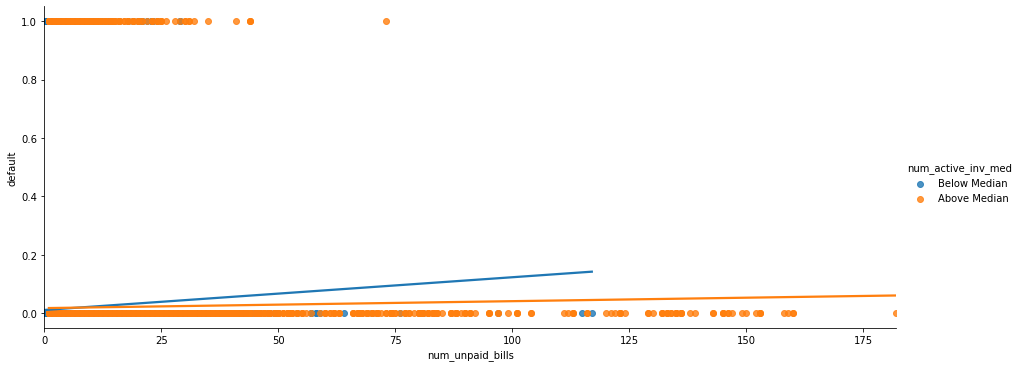

In [250]:
df_train2 = df_train.copy()
df_train2['num_active_inv_med'] = df_train2.num_active_inv > df_train2.num_active_inv.median()
df_train2['num_active_inv_med'] = np.where(df_train2.num_active_inv_med == False, "Below Median", "Above Median")
sns.lmplot(x='num_unpaid_bills', y='default', hue='num_active_inv_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

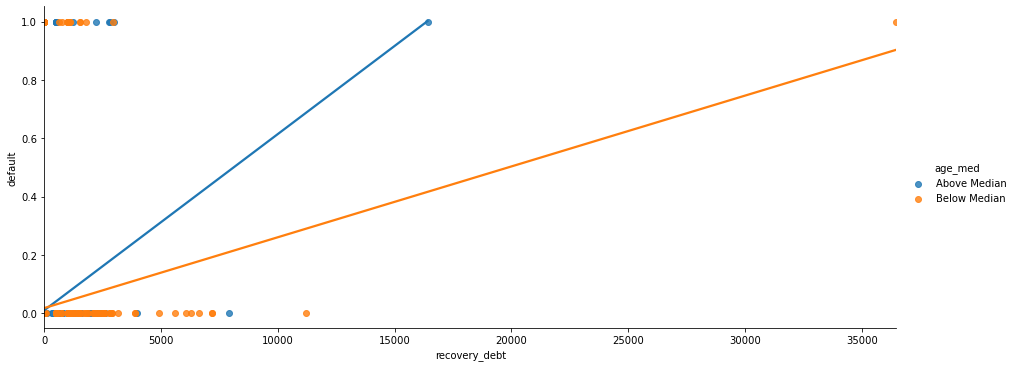

In [253]:
df_train2['age_med'] = df_train2.age > df_train2.age.median()
df_train2['age_med'] = np.where(df_train2.age_med == False, "Below Median", "Above Median")
sns.lmplot(x='recovery_debt', y='default', hue='age_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

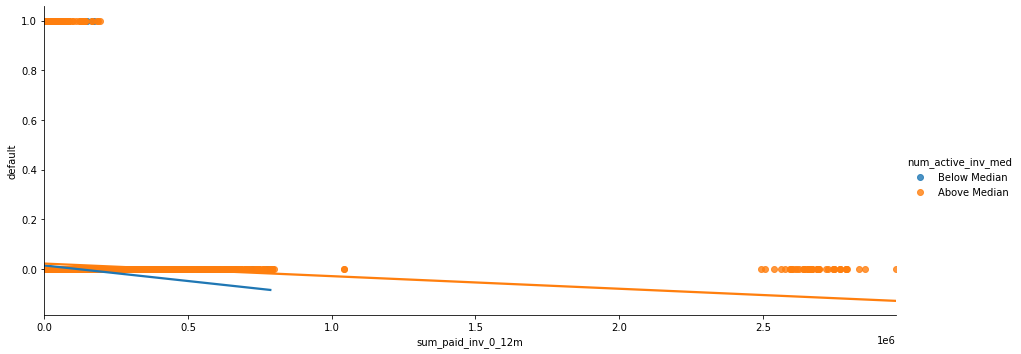

In [254]:
df_train2['num_active_inv_med'] = df_train2.num_active_inv > df_train2.num_active_inv.median()
df_train2['num_active_inv_med'] = np.where(df_train2.num_active_inv_med == False, "Below Median", "Above Median")
sns.lmplot(x='sum_paid_inv_0_12m', y='default', hue='num_active_inv_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

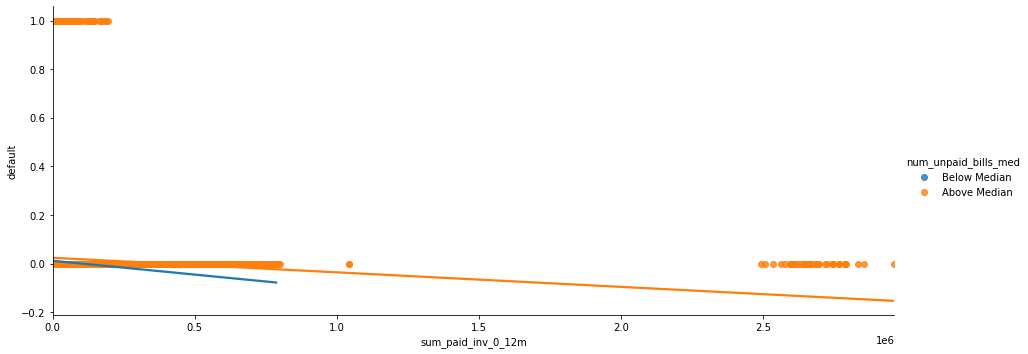

In [255]:
df_train2['num_unpaid_bills_med'] = df_train2.num_unpaid_bills > df_train2.num_unpaid_bills.median()
df_train2['num_unpaid_bills_med'] = np.where(df_train2.num_unpaid_bills_med == False, "Below Median", "Above Median")
sns.lmplot(x='sum_paid_inv_0_12m', y='default', hue='num_unpaid_bills_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

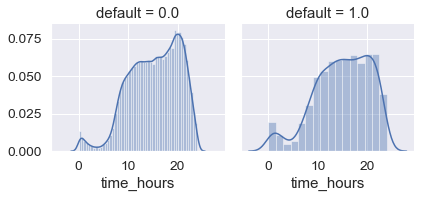

In [256]:
sns.set(font_scale=1.25)
g = sns.FacetGrid(df_train2, col="default") 
g.map(sns.distplot, "time_hours");

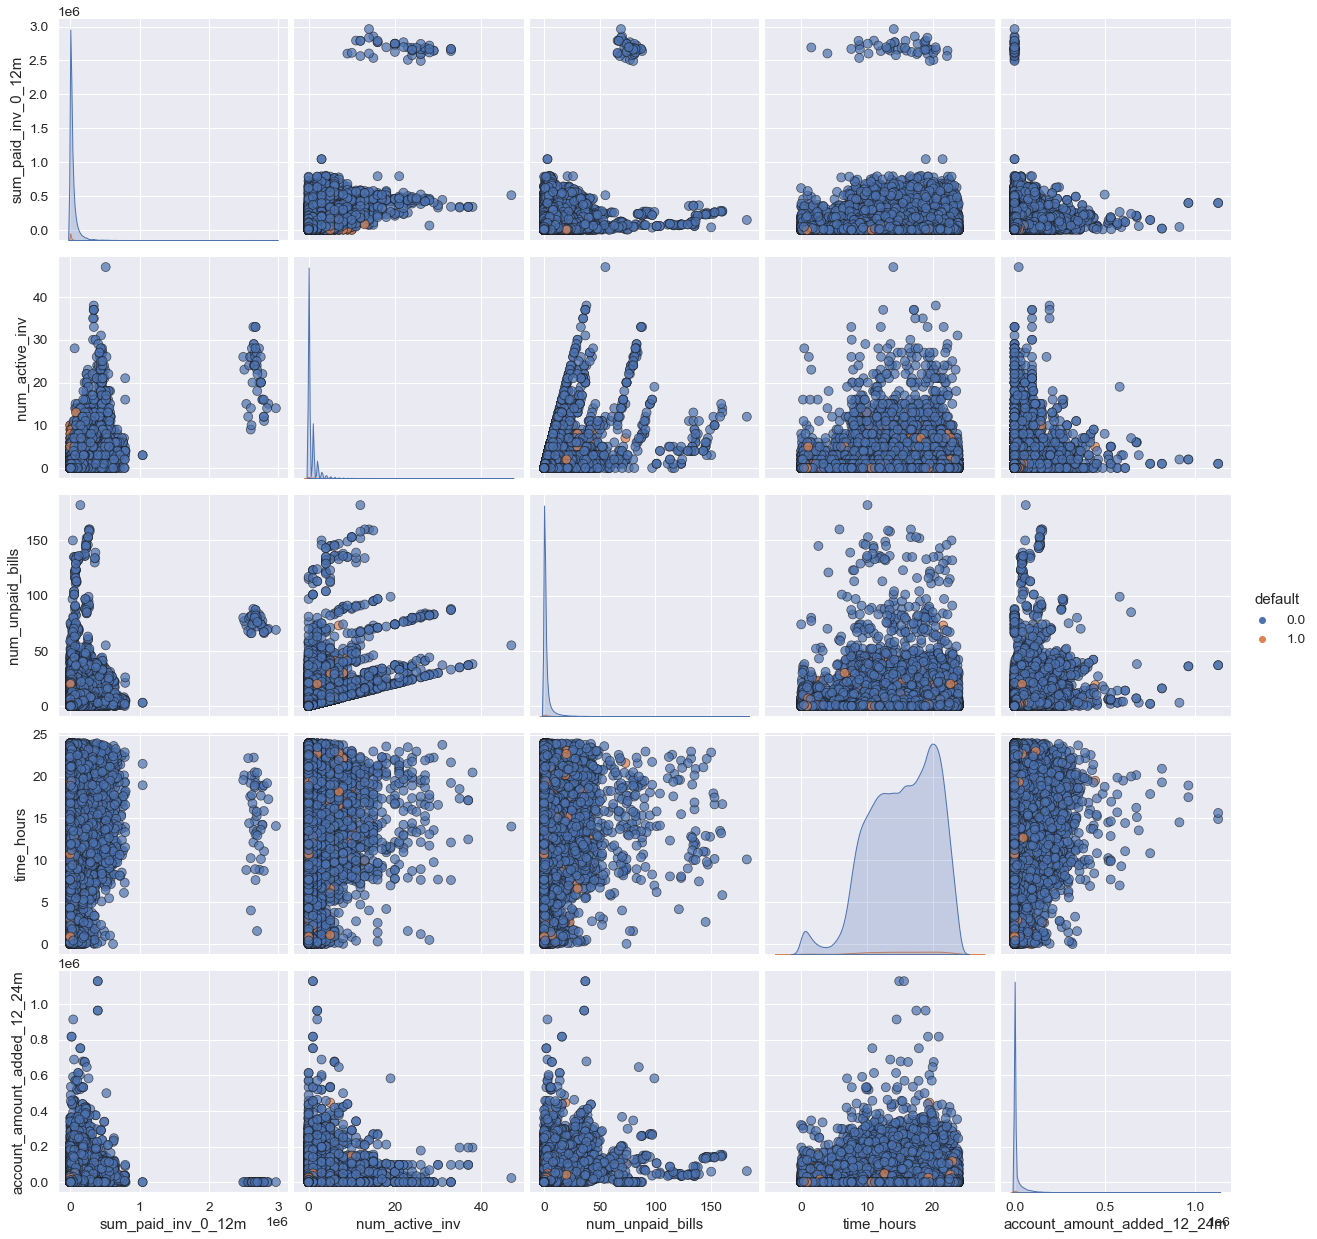

In [287]:
pair_cols = ["default", "sum_paid_inv_0_12m","num_active_inv","num_unpaid_bills","time_hours", "account_amount_added_12_24m"]

sns.pairplot(df_train2[pair_cols], hue = 'default', diag_kind = 'kde', 
             plot_kws = {'alpha': 0.7, 's': 80, 'edgecolor': 'k'}, size = 3.5)
plt.show()

We could not find any strong interaction between variables according to plots. There are more variables in data however we can not try each pair to seek for interaction. However, when we look at correlations above there are some variables having similar names even if they have low correlation coefficient between themselves. We assumed that these kind of variables had calculated in a similar way. Therefore, we can search for interactions among them.

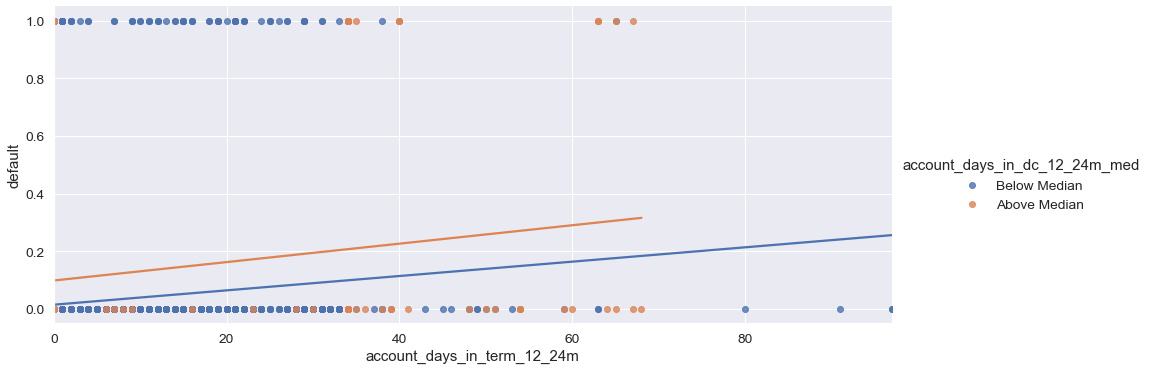

In [293]:
df_train2['account_days_in_dc_12_24m_med'] = df_train2.account_days_in_dc_12_24m > df_train2.account_days_in_dc_12_24m.median()
df_train2['account_days_in_dc_12_24m_med'] = np.where(df_train2.account_days_in_dc_12_24m_med == False, "Below Median", "Above Median")
sns.lmplot(x='account_days_in_term_12_24m', y='default', hue='account_days_in_dc_12_24m_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

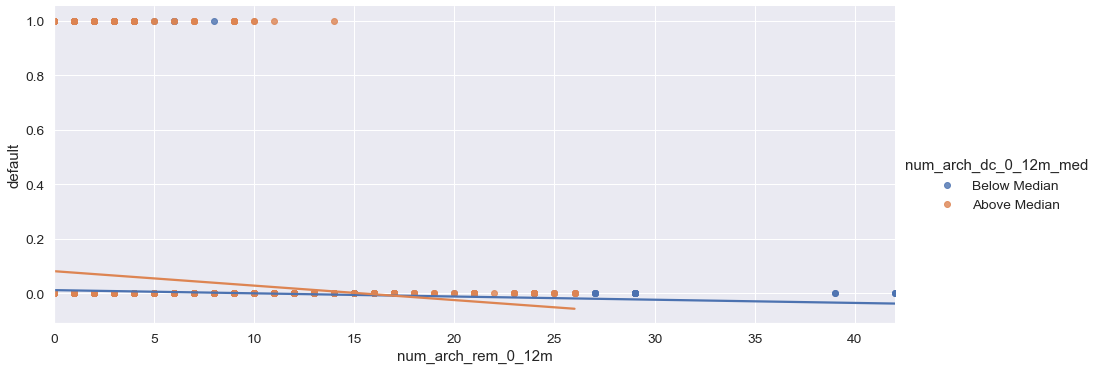

In [294]:
df_train2['num_arch_dc_0_12m_med'] = df_train2.num_arch_dc_0_12m > df_train2.num_arch_dc_0_12m.median()
df_train2['num_arch_dc_0_12m_med'] = np.where(df_train2.num_arch_dc_0_12m_med == False, "Below Median", "Above Median")
sns.lmplot(x='num_arch_rem_0_12m', y='default', hue='num_arch_dc_0_12m_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

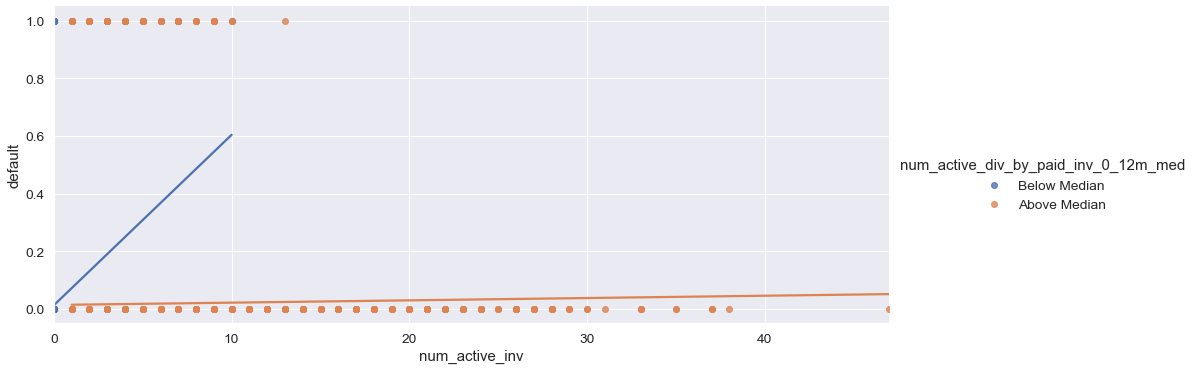

In [295]:
df_train2['num_active_div_by_paid_inv_0_12m_med'] = df_train2.num_active_div_by_paid_inv_0_12m > df_train2.num_active_div_by_paid_inv_0_12m.median()
df_train2['num_active_div_by_paid_inv_0_12m_med'] = np.where(df_train2.num_active_div_by_paid_inv_0_12m_med == False, "Below Median", "Above Median")
sns.lmplot(x='num_active_inv', y='default', hue='num_active_div_by_paid_inv_0_12m_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

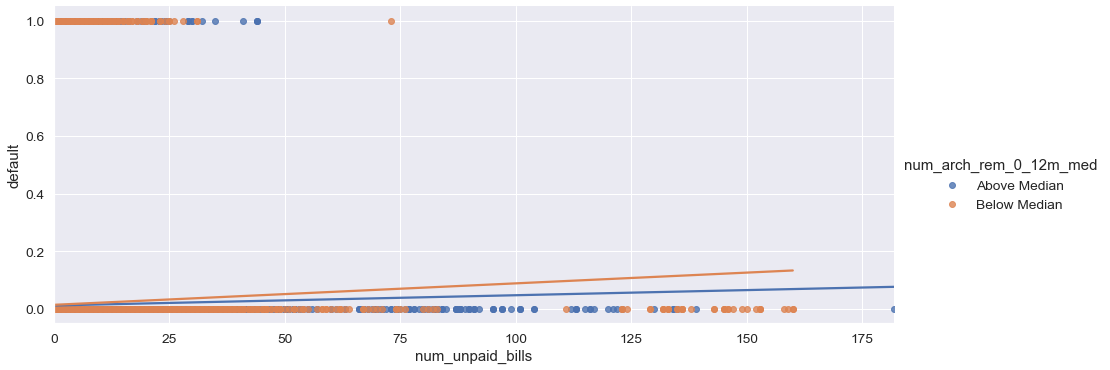

In [296]:
df_train2['num_arch_rem_0_12m_med'] = df_train2.num_arch_rem_0_12m > df_train2.num_arch_rem_0_12m.median()
df_train2['num_arch_rem_0_12m_med'] = np.where(df_train2.num_arch_rem_0_12m_med == False, "Below Median", "Above Median")
sns.lmplot(x='num_unpaid_bills', y='default', hue='num_arch_rem_0_12m_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

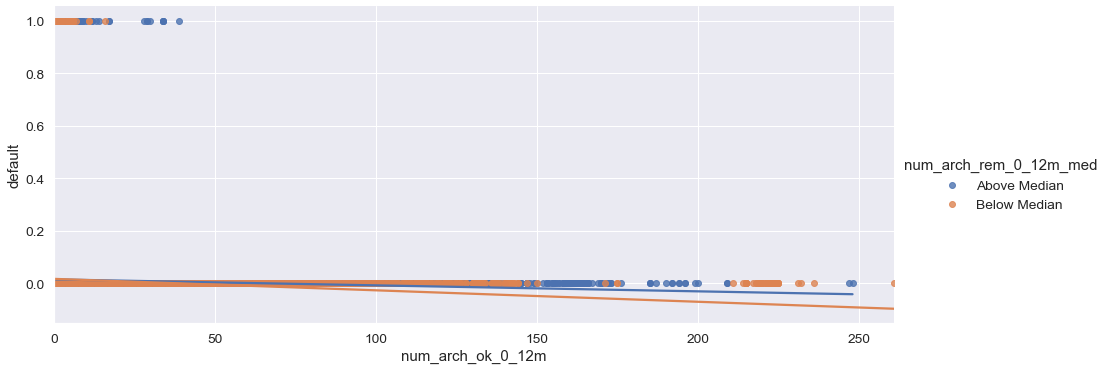

In [307]:
df_train2['num_arch_rem_0_12m_med'] = df_train2.num_arch_rem_0_12m > df_train2.num_arch_rem_0_12m.median()
df_train2['num_arch_rem_0_12m_med'] = np.where(df_train2.num_arch_rem_0_12m_med == False, "Below Median", "Above Median")
sns.lmplot(x='num_arch_ok_0_12m', y='default', hue='num_arch_rem_0_12m_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

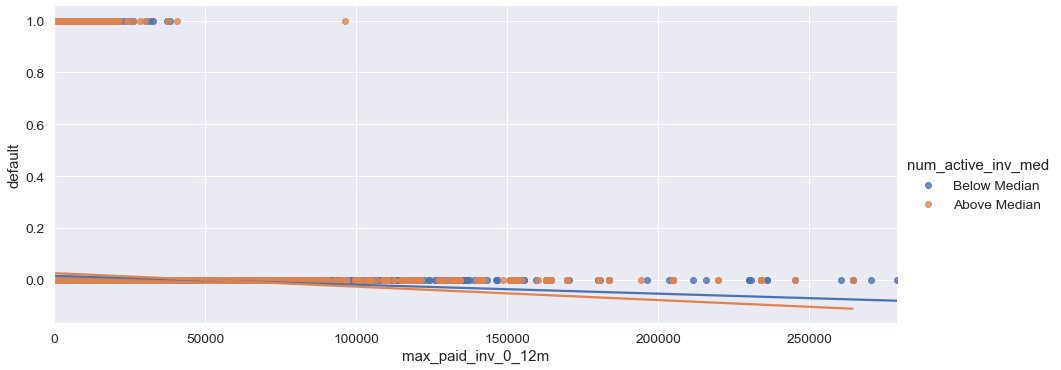

In [308]:
df_train2['num_active_inv_med'] = df_train2.num_active_inv > df_train2.num_active_inv.median()
df_train2['num_active_inv_med'] = np.where(df_train2.num_active_inv_med == False, "Below Median", "Above Median")
sns.lmplot(x='max_paid_inv_0_12m', y='default', hue='num_active_inv_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

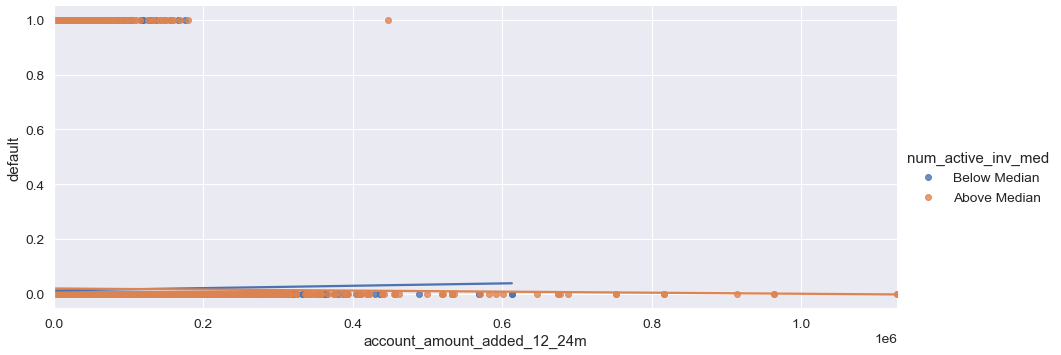

In [309]:
df_train2['num_active_inv_med'] = df_train2.num_active_inv > df_train2.num_active_inv.median()
df_train2['num_active_inv_med'] = np.where(df_train2.num_active_inv_med == False, "Below Median", "Above Median")
sns.lmplot(x='account_amount_added_12_24m', y='default', hue='num_active_inv_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

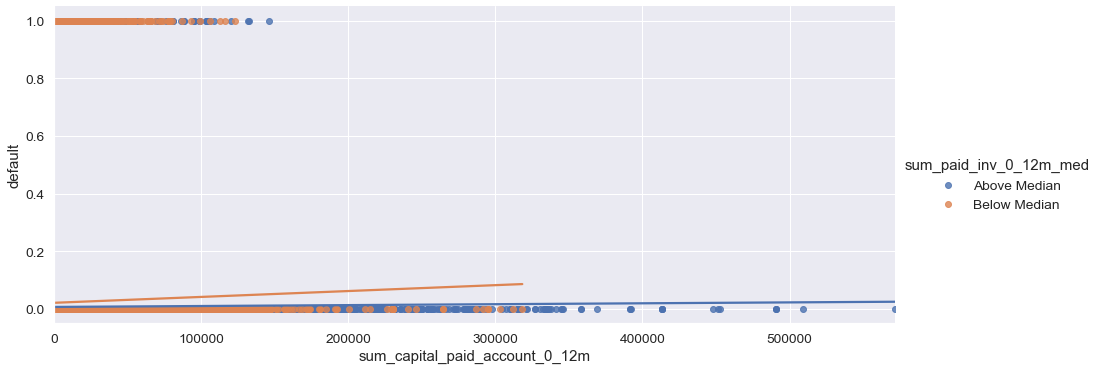

In [310]:
df_train2['sum_paid_inv_0_12m_med'] = df_train2.sum_paid_inv_0_12m > df_train2.sum_paid_inv_0_12m.median()
df_train2['sum_paid_inv_0_12m_med'] = np.where(df_train2.sum_paid_inv_0_12m_med == False, "Below Median", "Above Median")
sns.lmplot(x='sum_capital_paid_account_0_12m', y='default', hue='sum_paid_inv_0_12m_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

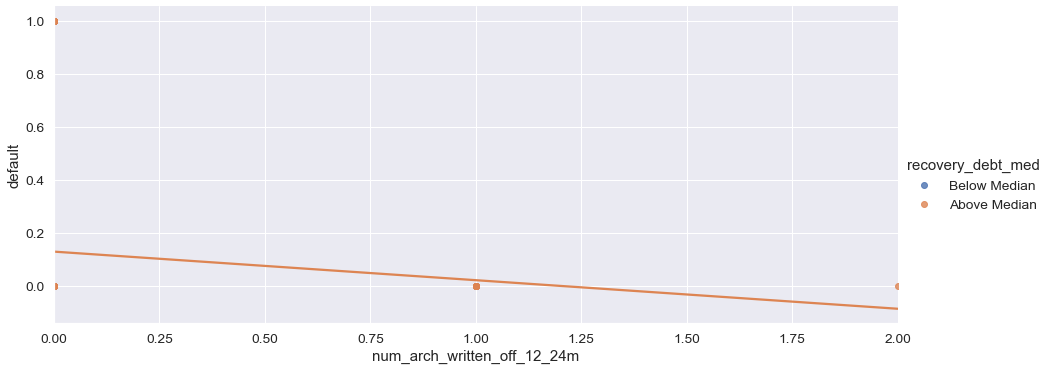

In [312]:
df_train2['recovery_debt_med'] = df_train2.recovery_debt > df_train2.recovery_debt.median()
df_train2['recovery_debt_med'] = np.where(df_train2.recovery_debt_med == False, "Below Median", "Above Median")
sns.lmplot(x='num_arch_written_off_12_24m', y='default', hue='recovery_debt_med', data=df_train2.loc[1:], ci=None, size=5, aspect=2.5)
plt.show()

We see that there is an interaction between num_arch_rem_0_12m and num_arch_dc_0_12m variables. Thus, we will add this interaction to training data.

In [24]:
X2["int_num_arch_rem_dc_0_12m"] = X2.num_arch_rem_0_12m * X2.num_arch_dc_0_12m
X2.shape

(89976, 47)

In [25]:
df_test2["int_num_arch_rem_dc_0_12m"] = df_test2.num_arch_rem_0_12m * df_test2.num_arch_dc_0_12m
df_test2.shape

(10000, 52)

In [180]:
#Lets split our data with a simple method called train_test_split:

x_train, x_test, y_train, y_test = train_test_split(X2, y_target, stratify=y_target, test_size=0.25)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((67482, 47), (22494, 47), (67482,), (22494,))

In [349]:
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
account_amount_added_12_24m,67482.0,12202.933123,35153.209240,0.000000,0.000000,0.000000,4930.750000,1.128654e+06
account_days_in_dc_12_24m,59422.0,0.209754,5.570989,0.000000,0.000000,0.000000,0.000000,3.500000e+02
account_days_in_rem_12_24m,59422.0,5.050756,22.924510,0.000000,0.000000,0.000000,0.000000,3.650000e+02
account_days_in_term_12_24m,59422.0,0.279021,2.889300,0.000000,0.000000,0.000000,0.000000,9.700000e+01
account_incoming_debt_vs_paid_0_24m,27440.0,1.441367,30.838335,0.000000,0.000000,0.154259,0.661956,3.914000e+03
age,67482.0,35.978943,12.985289,18.000000,25.000000,34.000000,45.000000,1.000000e+02
avg_payment_span_0_12m,51380.0,17.990297,12.778386,0.000000,10.833333,15.000000,21.142857,2.600000e+02
avg_payment_span_0_3m,34172.0,14.958473,10.244570,0.000000,8.408824,13.000000,18.281429,8.600000e+01
max_paid_inv_0_12m,67482.0,9230.657731,13587.759832,0.000000,2030.000000,6049.500000,11375.000000,2.643000e+05
max_paid_inv_0_24m,67482.0,11259.086023,15293.383086,0.000000,3375.000000,7585.000000,13803.750000,2.643000e+05


In [351]:
#Check variables with zero-variance in data. Zero- variance implies that varible does not consist of any information, indeed. 
#It has no spread in itself, thus this refers that it includes mostly the same value/s.
x_train2= x_train.copy()
#x_train3 = x_train2.drop(["avg_payment_span_3_12m"], axis =1)
v_thresh = VarianceThreshold(threshold= 0)
v_thresh.fit(x_train2[x_train2.select_dtypes(exclude = "object").columns].fillna(0))
v_thresh.get_support()
#The get_support returns a Boolean vector where True means that the variable does not have zero variance.

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Now, lets calculate features' individual importances:

In [353]:
#Information Gain:
x_train_num = x_train.select_dtypes(exclude="object")
x_train_cat = x_train.select_dtypes(include="object")

imp = mutual_info_classif(x_train_num.fillna(0),y_train)

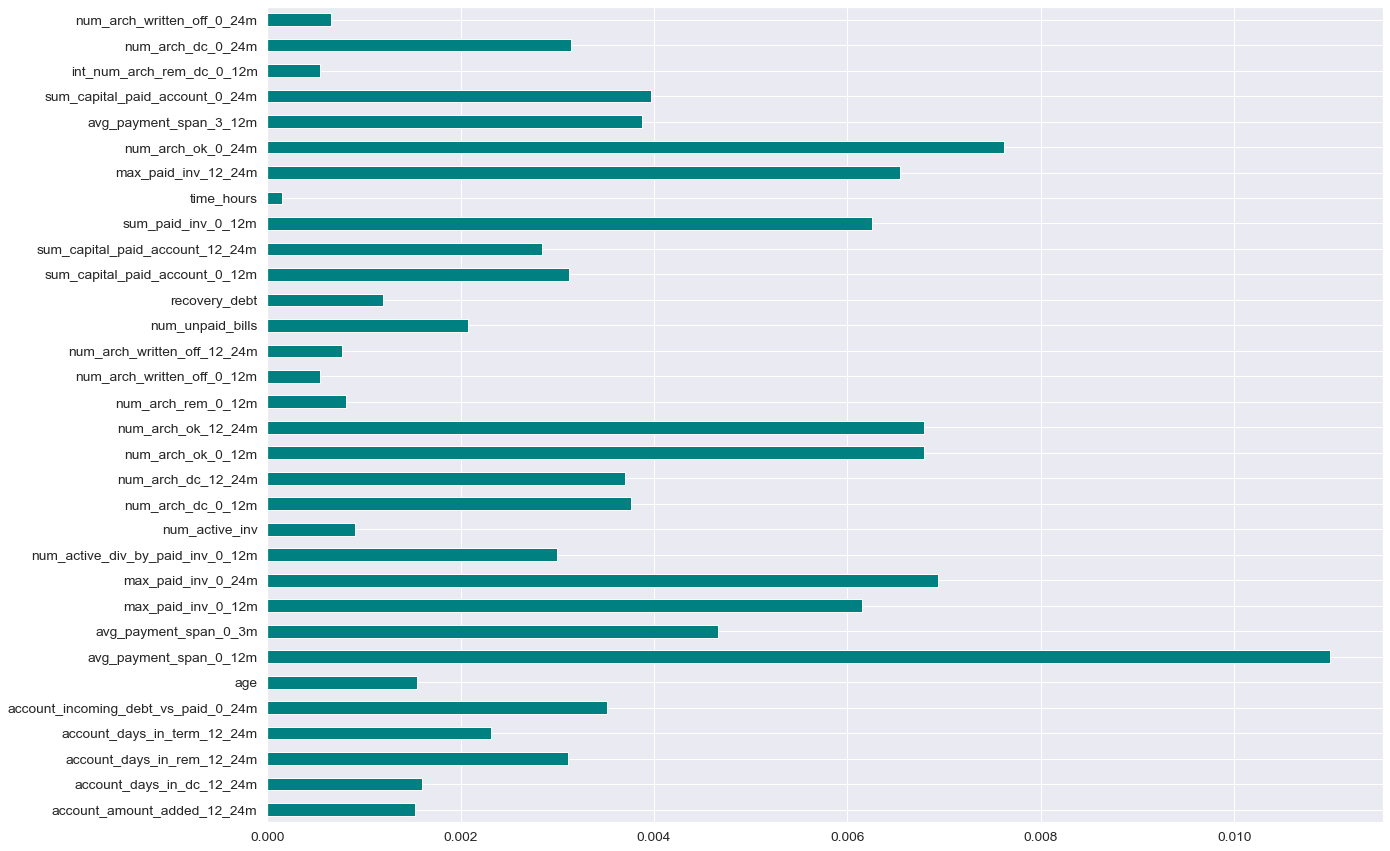

In [354]:
#plot importances
feat_importances = pd.Series(imp, x_train_num.columns[0:len(x_train_num.columns)])
feat_importances.plot(kind="barh", color="teal", figsize=(20,15))
plt.show()

In [355]:
#Orgering categorical variables based on Chi2:
le = LabelEncoder()
#first, we convert type of variables
x_train_cat = x_train_cat.fillna(x_train_cat.mode().iloc[0])
x_train_cat = x_train_cat.apply(le.fit_transform)


In [356]:
#Scores for categorical variables
imp_cat = mutual_info_classif(x_train_cat,y_train) #we can try another method to see importances, here

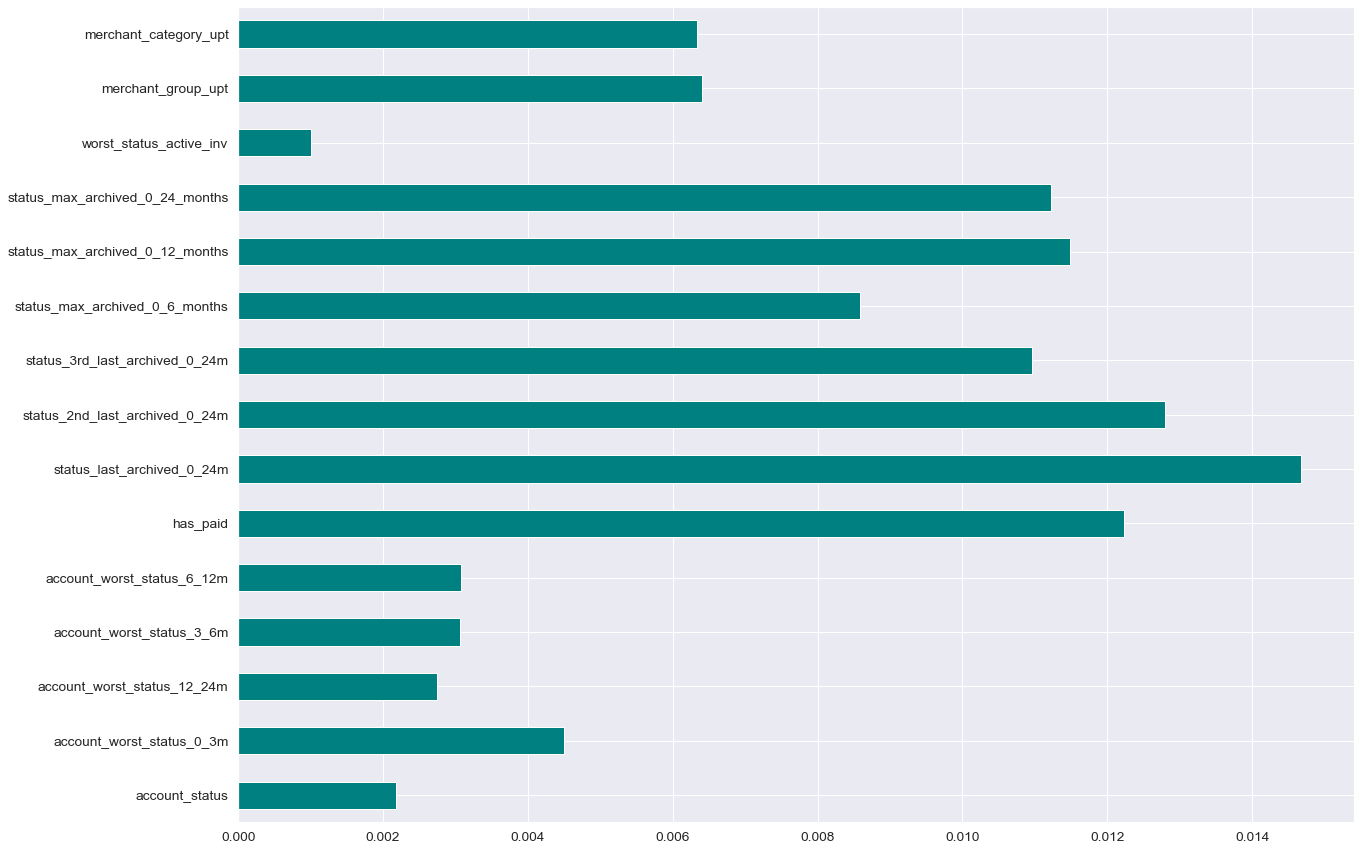

In [357]:
#plot importances
feat_importances_cat = pd.Series(imp_cat, x_train_cat.columns[0:len(x_train_cat.columns)])
feat_importances_cat.plot(kind="barh", color="teal", figsize=(20,15))
plt.show()

In [358]:
#Cardinality of categorical variables:
x_train[x_train.select_dtypes(include="object").columns].apply(pd.Series.nunique)

account_status                     4
account_worst_status_0_3m          4
account_worst_status_12_24m        4
account_worst_status_3_6m          4
account_worst_status_6_12m         4
has_paid                           2
status_last_archived_0_24m         5
status_2nd_last_archived_0_24m     5
status_3rd_last_archived_0_24m     5
status_max_archived_0_6_months     4
status_max_archived_0_12_months    5
status_max_archived_0_24_months    5
worst_status_active_inv            3
merchant_group_upt                 6
merchant_category_upt              9
dtype: int64

The number of categories of categorical variables are reasonable.

In [27]:
def top_value_ratio(x):
    return x.value_counts().idxmax(), x.value_counts().max()/len(x)*100

In [360]:
#Dominant value ratios:
x_train.apply(top_value_ratio)

,account_amount_added_12_24m,account_days_in_dc_12_24m,account_days_in_rem_12_24m,account_days_in_term_12_24m,account_incoming_debt_vs_paid_0_24m,account_status,account_worst_status_0_3m,account_worst_status_12_24m,account_worst_status_3_6m,account_worst_status_6_12m,...,worst_status_active_inv,merchant_group_upt,merchant_category_upt,max_paid_inv_12_24m,num_arch_ok_0_24m,avg_payment_span_3_12m,sum_capital_paid_account_0_24m,int_num_arch_rem_dc_0_12m,num_arch_dc_0_24m,num_arch_written_off_0_24m
0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,Entertainment,Diversified entertainment,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,71.303459,87.808601,78.397202,86.864645,12.991613,43.733144,38.385051,23.582585,35.351649,30.740049,...,26.787884,48.63371,38.457663,52.11612,7.307134,0.817996,92.937376,97.301503,2.794819,0.008891


In [25]:
top_freq = x_train.apply(top_value_ratio).T
top_freq.columns = ['Dominant_value','Dominant_ratio']
top_freq.sort_values(by="Dominant_ratio", ascending=False)

,Dominant_value,Dominant_ratio
recovery_debt,0.0,99.771791
int_num_arch_rem_dc_0_12m,0.0,97.271865
num_arch_dc_0_12m,0.0,95.699594
sum_capital_paid_account_0_24m,0.0,92.96405
account_days_in_dc_12_24m,0.0,87.853057
account_days_in_term_12_24m,0.0,86.897247
has_paid,True,85.024155
num_arch_written_off_0_12m,0.0,81.780327
account_days_in_rem_12_24m,0.0,78.44314
num_arch_rem_0_12m,0.0,76.678225


#### Start to feature selection ccording to information values and correlations, then modelling

In [367]:
feat_importances.sort_values(ascending = False)

avg_payment_span_0_12m                 0.010988
num_arch_ok_0_24m                      0.007614
max_paid_inv_0_24m                     0.006935
num_arch_ok_0_12m                      0.006788
num_arch_ok_12_24m                     0.006787
max_paid_inv_12_24m                    0.006548
sum_paid_inv_0_12m                     0.006251
max_paid_inv_0_12m                     0.006150
avg_payment_span_0_3m                  0.004660
sum_capital_paid_account_0_24m         0.003972
avg_payment_span_3_12m                 0.003877
num_arch_dc_0_12m                      0.003758
num_arch_dc_12_24m                     0.003696
account_incoming_debt_vs_paid_0_24m    0.003518
num_arch_dc_0_24m                      0.003139
sum_capital_paid_account_0_12m         0.003118
account_days_in_rem_12_24m             0.003106
num_active_div_by_paid_inv_0_12m       0.002998
sum_capital_paid_account_12_24m        0.002845
account_days_in_term_12_24m            0.002319
num_unpaid_bills                       0

In [370]:
print(get_top_abs_correlations(x_train[x_train.select_dtypes(exclude= "object").columns], 50))

num_arch_dc_0_24m                num_arch_written_off_0_24m         1.000000
sum_capital_paid_account_12_24m  num_arch_written_off_0_24m         1.000000
num_arch_written_off_0_12m       num_arch_written_off_0_24m         1.000000
num_arch_dc_12_24m               num_arch_written_off_0_24m         1.000000
                                 sum_capital_paid_account_12_24m    1.000000
num_arch_written_off_12_24m      sum_capital_paid_account_12_24m    1.000000
num_arch_dc_12_24m               num_arch_written_off_12_24m        1.000000
num_arch_written_off_12_24m      num_arch_dc_0_24m                  1.000000
                                 num_arch_written_off_0_24m         1.000000
num_arch_written_off_0_12m       num_arch_written_off_12_24m        1.000000
num_arch_ok_0_12m                num_arch_ok_0_24m                  0.999854
num_arch_dc_0_12m                num_arch_dc_0_24m                  0.963986
max_paid_inv_0_12m               max_paid_inv_0_24m                 0.888530

In [383]:
feat_num_imp = feat_importances.to_frame().reset_index()
corr_feats = get_top_abs_correlations(x_train[x_train.select_dtypes(exclude= "object").columns], 50).to_frame().reset_index()

In [380]:
num_corr_feats = pd.merge(corr_feats,feat_num_imp, how='left', left_on ="level_1" , right_on ="index").merge(feat_num_imp,how='left', left_on ="level_0" , right_on ="index" )
num_corr_feats.columns = ["feat1", "feat2","corr_coeff","index","feat2_imp","index_x","feat1_imp"]
num_corr_feats.drop(["index","index_x"], axis = 1, inplace = True)

In [381]:
num_corr_feats

,feat1,feat2,corr_coeff,feat2_imp,feat1_imp
0,num_arch_dc_0_24m,num_arch_written_off_0_24m,1.000000,0.000663,0.003139
1,sum_capital_paid_account_12_24m,num_arch_written_off_0_24m,1.000000,0.000663,0.002845
2,num_arch_written_off_0_12m,num_arch_written_off_0_24m,1.000000,0.000663,0.000545
3,num_arch_dc_12_24m,num_arch_written_off_0_24m,1.000000,0.000663,0.003696
4,num_arch_dc_12_24m,sum_capital_paid_account_12_24m,1.000000,0.002845,0.003696
5,num_arch_written_off_12_24m,sum_capital_paid_account_12_24m,1.000000,0.002845,0.000779
6,num_arch_dc_12_24m,num_arch_written_off_12_24m,1.000000,0.000779,0.003696
7,num_arch_written_off_12_24m,num_arch_dc_0_24m,1.000000,0.003139,0.000779
8,num_arch_written_off_12_24m,num_arch_written_off_0_24m,1.000000,0.000663,0.000779
9,num_arch_written_off_0_12m,num_arch_written_off_12_24m,1.000000,0.000779,0.000545


When we compared correlations and feature importances, we can see that some of generated variables caused correlation problem. In addition to this, their importance values are less than the others. On the other hand, a few varibles that we previously derived above did not cause any correlation problem and they had greater gain values than their components had which also induced a kind of relation problem in some way. Therefore, we eliminated this kind of variables before modelling.

In [28]:
num_feats_to_drop = ["num_arch_ok_0_12m",
                     "sum_capital_paid_account_12_24m",
                     "int_num_arch_rem_dc_0_12m",
                     "num_arch_written_off_0_24m",
                     "num_arch_dc_0_24m",
                     "avg_payment_span_3_12m",
                     "max_paid_inv_12_24m",
                     "recovery_debt", #dominant ratio is greater than 95%
                     "int_num_arch_rem_dc_0_12m" #dominant ratio is greater than 95%
]

In [368]:
feat_importances_cat.sort_values(ascending = False)

status_last_archived_0_24m         0.014673
status_2nd_last_archived_0_24m     0.012794
has_paid                           0.012228
status_max_archived_0_12_months    0.011487
status_max_archived_0_24_months    0.011224
status_3rd_last_archived_0_24m     0.010958
status_max_archived_0_6_months     0.008584
merchant_group_upt                 0.006407
merchant_category_upt              0.006336
account_worst_status_0_3m          0.004506
account_worst_status_6_12m         0.003071
account_worst_status_3_6m          0.003065
account_worst_status_12_24m        0.002753
account_status                     0.002179
worst_status_active_inv            0.001008
dtype: float64

When we checked correlations among categorical variables we saw that the only variable is "has_paid" that cause correlation indeed. However, its importance is relatively higher than others.

In [386]:
%%time
missing_data(x_train[x_train.select_dtypes(include ="object").columns])

Wall time: 178 ms


,Total,Percent,Types
account_status,36716,54.408583,object
account_worst_status_0_3m,36716,54.408583,object
account_worst_status_12_24m,45003,66.688895,object
account_worst_status_3_6m,38928,57.686494,object
account_worst_status_6_12m,40717,60.337572,object
has_paid,0,0.000000,object
status_last_archived_0_24m,0,0.000000,object
status_2nd_last_archived_0_24m,0,0.000000,object
status_3rd_last_archived_0_24m,0,0.000000,object
status_max_archived_0_6_months,0,0.000000,object


In [29]:
missing_table = missing_data(x_train[x_train.select_dtypes(include ="object").columns])
most_miss_cols_cat = list(missing_table[missing_table['Percent'] > 50].index)
most_miss_cols_cat

['account_status',
 'account_worst_status_0_3m',
 'account_worst_status_12_24m',
 'account_worst_status_3_6m',
 'account_worst_status_6_12m',
 'worst_status_active_inv']

In [30]:
missing_table = missing_data(x_train[x_train.select_dtypes(exclude ="object").columns])
most_miss_cols_num = list(missing_table[missing_table['Percent'] > 50].index)
most_miss_cols_num

['account_incoming_debt_vs_paid_0_24m',
 'num_arch_dc_12_24m',
 'num_arch_written_off_12_24m',
 'sum_capital_paid_account_12_24m',
 'num_arch_dc_0_24m',
 'num_arch_written_off_0_24m']

The variables above have more than 50 percent missing value ratio. In this case, we drop them because we will one hot encoder for categorical values and OHE does not allow missing values. Imputation is not the right approach here since we do not know further information about them. The same case is also valid for numerical varibles. Let's check also test data whether there exist completely missing variable rather than our target input, named default.

In [389]:
%%time
missing_data(df_test)

Wall time: 43.9 ms


,Total,Percent,Types
uuid,0,0.00,object
default,10000,100.00,float64
account_amount_added_12_24m,0,0.00,int64
account_days_in_dc_12_24m,1153,11.53,float64
account_days_in_rem_12_24m,1153,11.53,float64
account_days_in_term_12_24m,1153,11.53,float64
account_incoming_debt_vs_paid_0_24m,5958,59.58,float64
account_status,5439,54.39,float64
account_worst_status_0_3m,5439,54.39,float64
account_worst_status_12_24m,6706,67.06,float64


We already explored outliers. We can caption them with 99th quantile value for train data.

In [31]:
Q975 = x_train.quantile(0.975)
Q025 = x_train.quantile(0.025)
x_train2 = Q975.reset_index().T
x_train22 = Q025.reset_index().T
colnames= x_train2.iloc[0,:].to_list()
x_train2.columns = colnames
x_train22.columns = colnames
x_train2 = x_train2.iloc[1:]
x_train22 = x_train22.iloc[1:]

In [181]:
x_train3 = x_train.copy()
for cols in x_train3[x_train3.select_dtypes(exclude ="object").columns]:
    upper_lim = x_train2.iloc[0][cols]
    lower_lim = x_train22.iloc[0][cols]
    x_train3[cols] = np.where(x_train3[cols] >= upper_lim, upper_lim,
        np.where(x_train3[cols] <= lower_lim, lower_lim, x_train3[cols]))

In [100]:
drop_cols = list(set(most_miss_cols_cat + most_miss_cols_num + num_feats_to_drop ))
drop_cols

['account_incoming_debt_vs_paid_0_24m',
 'avg_payment_span_3_12m',
 'recovery_debt',
 'num_arch_dc_12_24m',
 'num_arch_written_off_12_24m',
 'int_num_arch_rem_dc_0_12m',
 'num_arch_written_off_0_24m',
 'account_worst_status_6_12m',
 'account_worst_status_12_24m',
 'max_paid_inv_12_24m',
 'account_status',
 'num_arch_dc_0_24m',
 'worst_status_active_inv',
 'sum_capital_paid_account_12_24m',
 'num_arch_ok_0_12m',
 'account_worst_status_0_3m',
 'account_worst_status_3_6m']

In [182]:
x_train3.drop(drop_cols, axis = 1, inplace = True)
x_train3.shape, y_train.shape

((67482, 30), (67482,))

<AxesSubplot:>

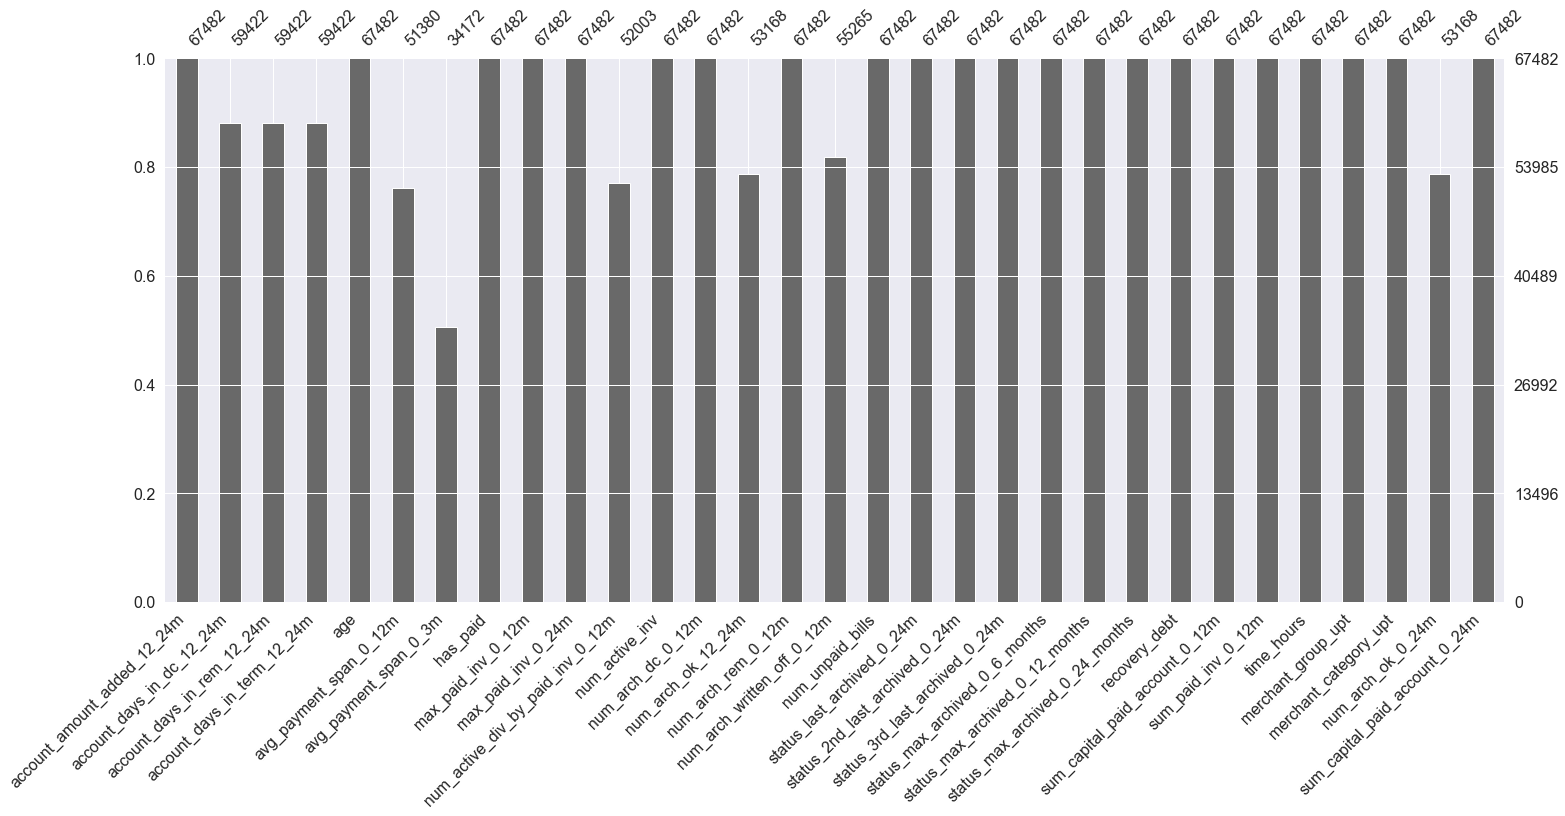

In [418]:
msno.bar(x_train3)

<AxesSubplot:>

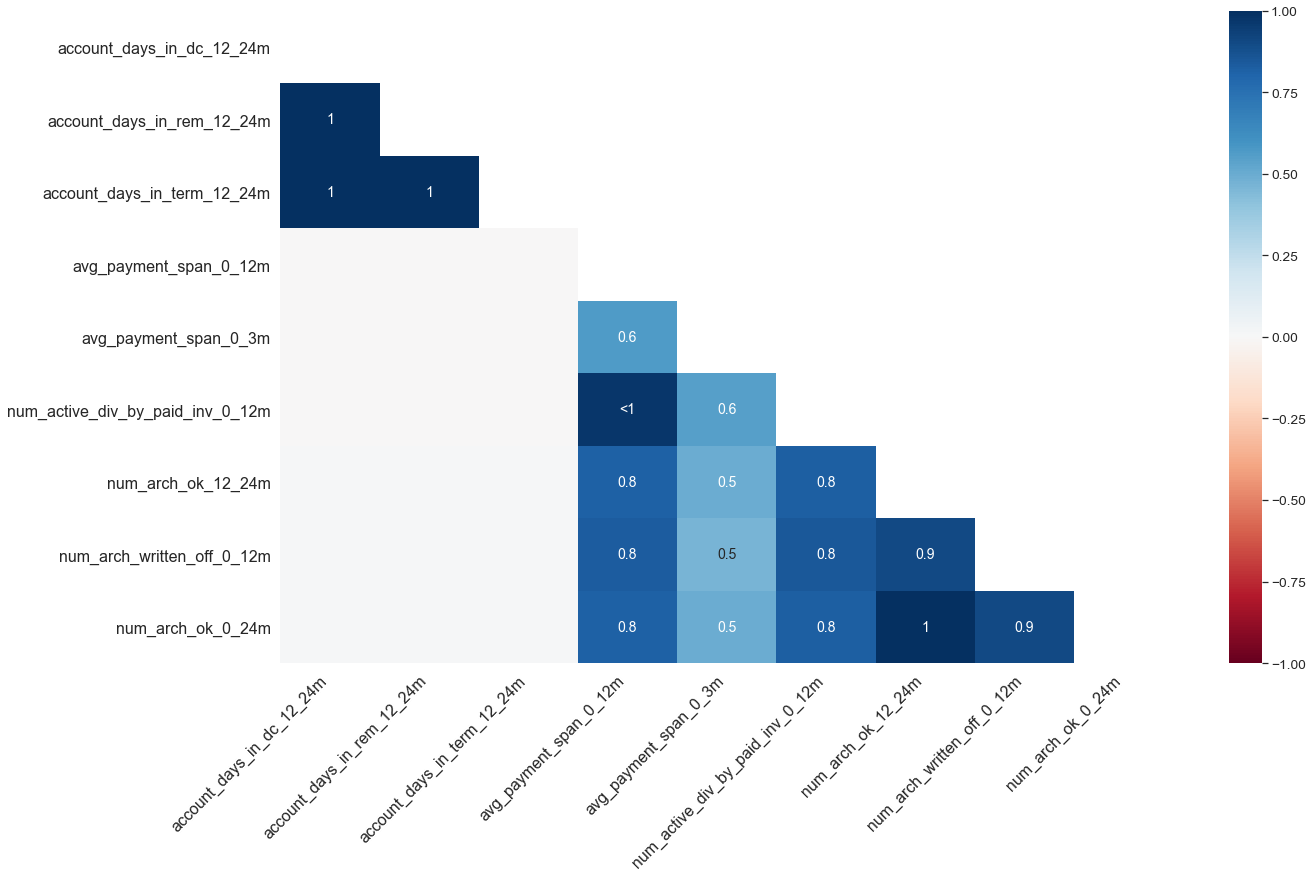

In [419]:
#The correlation heatmap below measures the nullity correlation. 
#How strongly the presence or absence of one variable affects the presence of another:
msno.heatmap(x_train3)

Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

Entries marked <1 or >-1 are have a correlation that is close to being exactingly negative or positive, but is still not quite perfectly so. This points to a small number of records in the dataset which are erroneous.

We can try to predict missing values for each columns if it has. However, these predictions will have also margin of errors. This may ne reflected on the final classification model. As another option, we can make iterative inmputation for numerical variables in case of that some classifiers do not allow missing values.

In [91]:
(y_train.value_counts()) / len(y_train) * 100

0.0    71.428878
1.0    28.571122
Name: default, dtype: float64

Our data is highly imbalanced. The rate of actual bads in target is too low. There are several methods like undersampling of majority class or oversampling of minority class. We will apply oversampling method called SMOTE during modelling process. In addition to this, we will try several classifiers and compare their performances.

Further, OHE and SMOTE does not allow missing values, therefore we use imputer and we scale data since some classifiers are sensitive to big differences in scales of variables.

#### Create a pipeline for data transformation:

In [35]:
pipe_cat = Pipeline([
                     
                     ("imp",imp.SimpleImputer(strategy="most_frequent")),
                     ("ohe", prp.OneHotEncoder(handle_unknown="ignore"))
])

pipe_num = Pipeline([  
                     
                     ("scale", prp.StandardScaler()),
                     ("imp", imp.IterativeImputer())
])


ct = ColumnTransformer([
                        
                        ("cat", pipe_cat,x_train3.select_dtypes(include= "object").columns), 
                        ("num", pipe_num,x_train3.select_dtypes(exclude= "object").columns)
])
np.set_printoptions(suppress=True)

#### Selecting model according to model scores

AUC Score for SGDClassifier : 0.8671145079805826
AUC Score for RandomForestClassifier : 0.8529908649448374
AUC Score for XGBClassifier : 0.8570989535729631
AUC Score for LogisticRegression : 0.8748001539379617
AUC Score for SVC : 0.807608339256658
AUC Score for KNeighborsClassifier : 0.6916287564554278


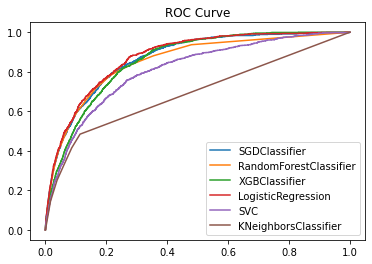

In [35]:
"""""
for est in [SGDClassifier(), RandomForestClassifier(), XGBClassifier(), LogisticRegression(), SVC(), 
            KNeighborsClassifier()]:
    pipe_final=imbPipe.Pipeline([
                         ("ct",ct),
                         ("scaler", prp.StandardScaler()),
                         ("imp", imp.IterativeImputer()),
                         ("smote", SMOTE(sampling_strategy=0.4)),
                         ("clf", est)
    ])

    if hasattr(est, "decision_function"):
        m = "decision_function"
    else:
        m = "predict_proba"
    y_preds = []
    scores = mdl.cross_val_predict(pipe_final, x_train3, y_train, cv=5, method=m)

    if not hasattr(est, "decision_function"):
        scores = scores[:, 1]
    
    #y_preds["est"] = scores
    
    print("AUC Score for {} : {}".format(est.__class__.__name__, met.roc_auc_score(y_train, scores)))
    
    fpr, tpr, thresholds = met.roc_curve(y_train, scores)
    plt.plot(fpr, tpr, label = est.__class__.__name__)

plt.title("ROC Curve")
plt.legend()
plt.show()

Logistic Regresssion and SGDClassifier gave similar output. Although Logit classifier had slightly higher AUC value, we focused on SGDClassifier.

#### Hyper- Parameter tuning for SGD Classifier

In [37]:
"""""
pipe_sgd=imbPipe.Pipeline([
                         ("ct",ct),
                         ("scaler", prp.StandardScaler()),
                         ("imp", imp.IterativeImputer()),
                         ("smote", SMOTE(sampling_strategy=0.4)),
                         ("sgd", SGDClassifier())
])


param_grid = {
    'sgd__l1_ratio': np.linspace(0, 1, num=10),
    'sgd__alpha': [0.001,0.01,0.1]
}

grid = mdl.GridSearchCV(pipe_sgd, param_grid, cv=3, n_jobs=-1, scoring='roc_auc')
grid.fit(x_train3, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('imp',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['has_paid', 'status_last_archived_0_24m',
       'status_2nd_last_archived_0_24m', 'status_3rd_last_archived_0_24m',
       'status_max_archived_0_6_months', 's...
       'num_arch_ok_0_24m', 'sum_capital_paid_account_0_24m'],
      dtype='object'))])),
                                       ('scaler', StandardScal

In [38]:
"""""
grid.best_params_

{'sgd__alpha': 0.01, 'sgd__l1_ratio': 0.8888888888888888}

In [183]:
x_train3.shape, y_train.shape, x_test[x_train3.columns].shape, y_test.shape

((67482, 30), (67482,), (22494, 30), (22494,))

In [184]:
encoder = prp.OneHotEncoder(categories = "auto", handle_unknown = "error", drop='first')
x_one_hot = encoder.fit_transform(x_train3[x_train3.select_dtypes(include= "object").columns])
x_one_hot_test = encoder.transform(x_test[x_train3.select_dtypes(include= "object").columns])

x_one_hot = pd.DataFrame(x_one_hot.toarray())
x_one_hot_test = pd.DataFrame(x_one_hot_test.toarray())

In [185]:
x_one_hot.shape, x_one_hot_test.shape

((67482, 37), (22494, 37))

In [112]:
print("Saving the encoder to  one_hot_encoder.pkl file ")
joblib.dump(encoder,"one_hot_encoder.pkl")

Saving the encoder to  one_hot_encoder.pkl file 


['one_hot_encoder.pkl']

In [186]:
cat_imp = imp.SimpleImputer(strategy="most_frequent")
x_one_hot_imp =  pd.DataFrame(cat_imp.fit_transform(x_one_hot))
x_one_hot_test_imp =  pd.DataFrame(cat_imp.transform(x_one_hot_test))

In [187]:
org_cat_cols= x_train3.select_dtypes(include= "object").columns

In [115]:
print("Saving the categorical imputer to  simple_imputer.pkl file ")
joblib.dump(cat_imp,"simple_imputer.pkl")

Saving the categorical imputer to  simple_imputer.pkl file 


['simple_imputer.pkl']

In [188]:
#num_imp= imp.IterativeImputer()
x_num_imp =  pd.DataFrame(pipe_num.fit_transform(x_train3[x_train3.select_dtypes(exclude= "object").columns]))
x_num_imp_test =  pd.DataFrame(pipe_num.transform(x_test[x_train3.select_dtypes(exclude= "object").columns]))

In [117]:
print("Saving the numerical imputer pipeline to iterative_imputer.pkl file")
joblib.dump(pipe_num,"iterative_imputer.pkl")

Saving the numerical imputer pipeline to iterative_imputer.pkl file


['iterative_imputer.pkl']

In [189]:
x_num_imp.columns = x_train3.select_dtypes(exclude= "object").columns
x_num_imp_test.columns = x_train3.select_dtypes(exclude= "object").columns

In [190]:
x_final_train = pd.concat([x_num_imp, x_one_hot], axis=1)
x_final_test = pd.concat([x_num_imp_test, x_one_hot_test_imp], axis=1)

In [191]:
print('Shape of x_one_hot dataframe: {}'.format(x_final_train.shape))
print('Number of possitive and negative case in target variable: \n{}'.format(y_train.value_counts()))

Shape of x_one_hot dataframe: (67482, 58)
Number of possitive and negative case in target variable: 
0.0    66516
1.0      966
Name: default, dtype: int64


### Handling imbalanced data:

###### Use the right evaluation metrics

Precision/Specificity: how many selected instances are relevant.

Recall/Sensitivity: how many relevant instances are selected.

F1 score: harmonic mean of precision and recall.

MCC: correlation coefficient between the observed and predicted binary classifications.

AUC: relation between true-positive rate and false positive rate.

###### Resample the training set

Under-sampling: As we only 66516 positive cases and 966 negative cases. If we apply Under-sampling technique then we will lose lot of information.

Over-sampling : As we have only 66516 possitive cases and 966 negative cases, if we apply over-sampling technique then we will not lose any inforamtion and our model will be better.

In [192]:
# transform the dataset
oversample = SMOTE(sampling_strategy=0.4)
x_final_train2, y_train2 = oversample.fit_resample(x_final_train, y_train)

In [193]:
y_train2.value_counts(), x_final_train2.shape

(0.0    66516
 1.0    26606
 Name: default, dtype: int64,
 (93122, 58))

In [194]:
#Fit the SGD Classifier which we choose above
sgd_model = SGDClassifier(alpha=0.01, l1_ratio = 0.8888888888888888)
sgd_model.fit(x_final_train2, y_train2)

SGDClassifier(alpha=0.01, l1_ratio=0.8888888888888888)

In [195]:
test_pred = sgd_model.predict(x_final_test)

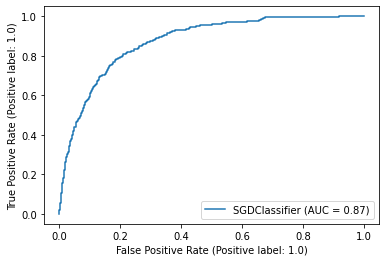

In [196]:
met.plot_roc_curve(sgd_model, x_final_test, y_test)

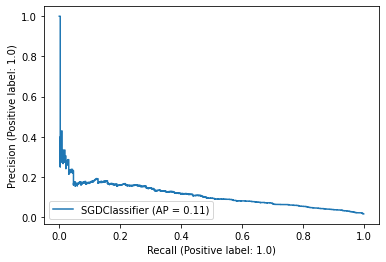

In [197]:
met.plot_precision_recall_curve(sgd_model, x_final_test, y_test)

In [132]:
print('AUC = {:.5f}'.format(met.roc_auc_score(y_test, test_pred)))
print('Average Precision = {:.5f}'.format(met.average_precision_score(y_test, test_pred)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(met.accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(met.precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(met.recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(met.f1_score(y_test, test_pred)))

print('\nClassification Report')
print(met.classification_report(y_test, test_pred))

AUC = 0.78101
Average Precision = 0.06088

Using 0.5 as threshold:
Accuracy = 0.89108
Precision = 0.08405
Recall = 0.66770
F1 score = 0.14931

Classification Report
              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94     22172
         1.0       0.08      0.67      0.15       322

    accuracy                           0.89     22494
   macro avg       0.54      0.78      0.55     22494
weighted avg       0.98      0.89      0.93     22494



In [135]:
print("Saving the model again to default_predictor_sgd.pkl file ")
joblib.dump(sgd_model, "default_predictor_sgd.pkl")

Saving the model again to default_predictor_sgd.pkl file 


['default_predictor_sgd.pkl']

In [136]:
joblib.dump(list(x_train3.columns),"Prob_Default_Klarna_InputNames3.pkl")

['Prob_Default_Klarna_InputNames3.pkl']

### Apply model on prediction 

This notebook is mainly used for data exploration. In order to have the flexibility to train the model on new data, I have written modularized python script called "train_model.py"

In the final step this script will store the model in a pickle file.

Command to run the train_model.py: python train_model.py

In [249]:
import train_model

In [250]:
test_dataset= train_model.load_data(DATASET_PATH)

Loading the data
Successfully uploaded the data


In [225]:
DATASET_PATH = os.getcwd() + "/dataset.csv"
TARGET = "default"
REQUIRED_COLUMNS = ['account_amount_added_12_24m', 'account_days_in_dc_12_24m',
       'account_days_in_rem_12_24m', 'account_days_in_term_12_24m', 'age',
       'avg_payment_span_0_12m', 'avg_payment_span_0_3m', 'has_paid',
       'max_paid_inv_0_12m', 'max_paid_inv_0_24m',
       'num_active_div_by_paid_inv_0_12m', 'num_active_inv',
       'num_arch_dc_0_12m', 'num_arch_ok_12_24m', 'num_arch_ok_0_12m', 'num_arch_rem_0_12m',
       'num_arch_written_off_0_12m', 'num_unpaid_bills',
       'status_last_archived_0_24m', 'status_2nd_last_archived_0_24m',
       'status_3rd_last_archived_0_24m', 'status_max_archived_0_6_months',
       'status_max_archived_0_12_months', 'status_max_archived_0_24_months',
       'sum_capital_paid_account_0_12m', 'sum_capital_paid_account_12_24m', 'sum_paid_inv_0_12m', 'time_hours',
       'merchant_group', 'merchant_category']

In [242]:
def prepare_data(df):
    """function to prepare data in order to pass as an input to our model"""

    print('Preparating the data')
    # 1. Check for default column in test data
    if TARGET in df.columns:
        df = df[df["default"].isna()].drop(["default"], axis=1).reset_index(drop=True)
    
   

    # 2. Check for all required columns
    for col_name in REQUIRED_COLUMNS:
        if col_name not in df.columns:
            print('Writing the data to csv file where required column values are missing')
            df[df[REQUIRED_COLUMNS].isnull().any(axis=1)].to_csv(
                'required_columns_values_missing.csv')
            raise Exception('Required column  is missing:{}', format(col_name))

            

    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)


    #3. Create 2 new columns and prepare others in test data
    
    df["num_arch_ok_0_24m"] = df.num_arch_ok_0_12m + df.num_arch_ok_12_24m
    df["sum_capital_paid_account_0_24m"] = df.sum_capital_paid_account_0_12m + df.sum_capital_paid_account_12_24m
    
    df = df.assign(merchant_category_upt = np.where(df['merchant_category'].isin(['Diversified electronics', 'Prints & Photos',
       'Children Clothes & Nurturing products', 'Pet supplies',
       'Electronic equipment & Related accessories', 'Hobby articles',
       'Jewelry & Watches', 'Prescription optics', 'Body & Hair Care',
       'Automotive Parts & Accessories',
       'Diversified Health & Beauty products',
       'Diversified Home & Garden products', 'Decoration & Art',
       'Video Games & Related accessories', 'Cosmetics', 'Dating services',
       'Children toys', 'Diversified erotic material',
       'Tools & Home improvement', 'Furniture', 'Pharmaceutical products',
       'Personal care & Body improvement', 'Fragrances',
       'Adult Shoes & Clothing', 'Digital services', 'Food & Beverage',
       'Travel services', 'Costumes & Party supplies', 'Music & Movies',
       'Wheels & Tires', 'Collectibles', 'Kitchenware', 'Underwear',
       'Household electronics (whitegoods/appliances)',
       'Erotic Clothing & Accessories', 'Non',
       'Musical Instruments & Equipment', 'Tobacco', 'Safety products',
       'Diversified Jewelry & Accessories', 'Car electronics', 'Sex toys',
       'Plants & Flowers', 'Bags & Wallets',
       'Office machines & Related accessories (excl. computers)',
       'Cleaning & Sanitary', 'Event tickets', 'Wine, Beer & Liquor',
       'Education']),'Other', df['merchant_category']))
    
    
    df = df.assign(merchant_group_upt = np.where(df['merchant_group'].isin(['Home & Garden', 'Electronics', 'Intangible products',
       'Jewelry & Accessories', 'Automotive Products', 'Erotic Materials',
       'Food & Beverage']),'Other', df['merchant_group']))
    
    df['has_paid'] = df['has_paid'].astype('object')
    
    # 4. Select columns of training data    
    model_columns = joblib.load("Prob_Default_Klarna_InputNames3.pkl")
    uuid = df["uuid"]
    df = df[model_columns]
    for col in df.filter(regex='status').columns:
        df[col] = df[col].astype('object')

    # 5. Impute data for numerical columns :
    
    df_numerical = df[df.select_dtypes(exclude = "object").columns]
    
    # load iterative imputer from disk
    imputer = joblib.load("iterative_imputer.pkl")
    df_num_imp = imputer.transform(df_numerical)
    df_num_imp = pd.DataFrame(df_num_imp)
    df_num_imp.columns = df_numerical.columns


    # 5.Categorical column data preparation
    
    df_categorical = df[df.select_dtypes(include = "object").columns]
    
    # load one hot encoder from disk
    
    simp_imp = joblib.load("simple_imputer.pkl")
    one_hot_encoder = joblib.load("one_hot_encoder.pkl")
    df_one_hot = one_hot_encoder.transform(df_categorical)
    df_one_hot = simp_imp.transform(pd.DataFrame(df_one_hot.toarray()))
    df_one_hot = pd.DataFrame(df_one_hot)
    df_one_hot.reset_index()
    df_final = pd.concat([uuid, df_num_imp,
                          df_one_hot], axis=1)

    print('Data preparation finished successfully')
    return df_final


In [243]:
df_fin= prepare_data(test_dataset)

Preparating the data
Data preparation finished successfully


In [247]:
def predict_default(df_final):
    """This function is used to predict the default and write the result to prediction.csv file"""

    # load model from disk
    sgd_model = joblib.load("default_predictor_sgd.pkl")

    if 'uuid' in df_final.columns:

        df_final['default_prediction'] = sgd_model.predict(df_final.drop(['uuid'], axis=1))
        prediction = df_final[['uuid', 'default_prediction']]

    else:
        df_final['default_prediction'] = sgd_model.predict(df_final)
        prediction = df_final['default_prediction']

    prediction.to_csv('prediction.csv')

    print('Successfully predicted the data, please check: prediction.csv')

In [248]:
predict_default(df_fin)

Successfully predicted the data, please check: prediction.csv
